In [ ]:
# pip install networkx matplotlib
# !pip install doubleml

In [ ]:
!pip install doubleml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.3/443.3 kB 7.2 MB/s eta 0:00:00


In [ ]:
from scipy.stats import truncnorm, lognorm, beta
from sklearn.model_selection import train_test_split
import uuid
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy as scipy
from copy import deepcopy
import math
from scipy.stats import multivariate_normal
from scipy.stats import t, chi2, f, norm, poisson, binom, uniform, expon, logistic
import seaborn
import networkx as nx
from statsmodels.api import OLS
from statsmodels.tools import add_constant
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import doubleml as dml
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
np.random.seed(123)

# Генерация и предварительная обработка данных

**Целевая переменная:** стоимость покупки в мобильном приложении, (сумма покупки за все время в рублях)

**Бинарная переменная:** Подписка на push-уведомления (0 – пользователь не подписан на push-уведомления, 1 – подписан).

**Контрольные переменные:**

*Непрерывные:*

• Время, проведенное в приложении за последние 7 дней

• Возраст пользователя

• Лояльность (ненабюдаемая переменная)

*Бинарная:*

• Пол

• Новый пользователь (менее 7 дней)

• Добавлял товар в корзину (за последние 7 дней)

**Инструментальная переменная:**

Тип устройства (бинарная) – iOS (1) или Android (0).

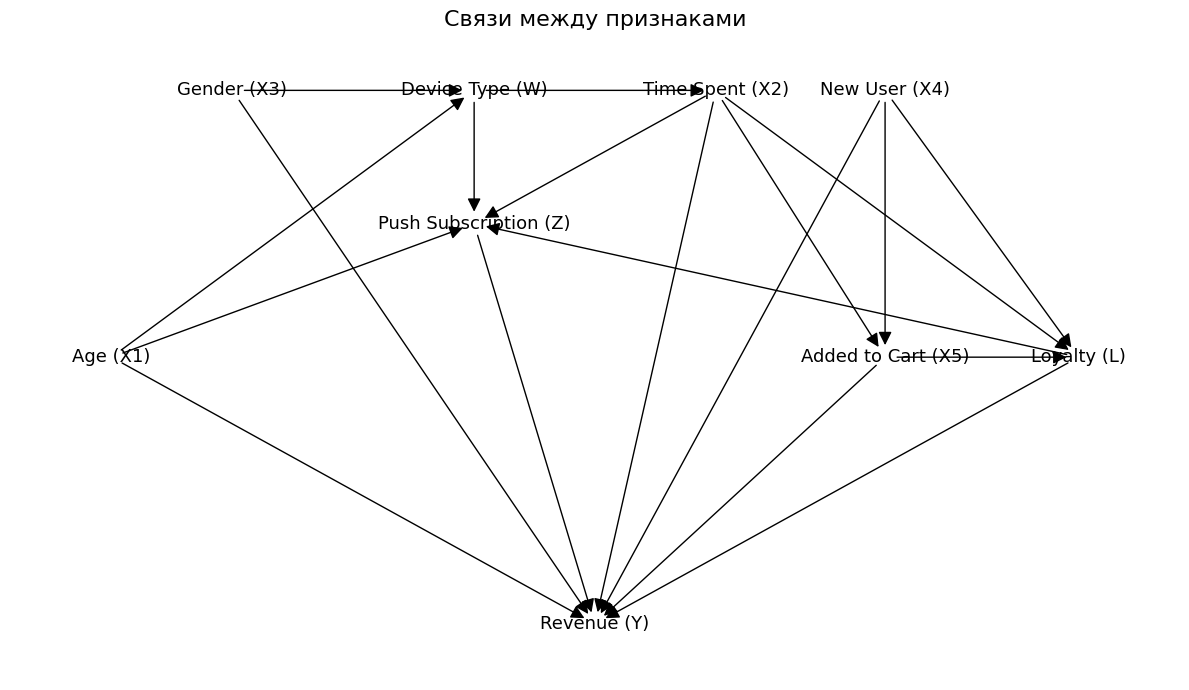

In [ ]:
G = nx.DiGraph()

nodes = {
    'Y': 'Revenue (Y)',
    'Z': 'Push Subscription (Z)',
    'W': 'Device Type (W)',
    'X1': 'Age (X1)',
    'X2': 'Time Spent (X2)',
    'X3': 'Gender (X3)',
    'X4': 'New User (X4)',
    'X5': 'Added to Cart (X5)',
    'L': 'Loyalty (L)'
}
G.add_nodes_from(nodes)

edges = [
    ('Z', 'Y'),
    ('X1', 'Y'),
    ('X2', 'Y'),
    ('X3', 'Y'),
    ('X4', 'Y'),
    ('X5', 'Y'),
    ('L', 'Y'),
    ('W', 'Z'),
    ('X1', 'Z'),
    ('X2', 'Z'),
    ('L', 'Z'),
    ('W', 'X2'),
    ('X2', 'X5'),
    ('X4', 'X5'),
    ('X3', 'W'),
    ('X1', 'W'),
    ('X2', 'L'),
    ('X4', 'L'),
    ('X5', 'L')
]
G.add_edges_from(edges)

pos = {
    'X1': (-2, 1),
    'X3': (-1.5, 2),
    'X4': (1.2, 2),
    'X2': (0.5, 2),
    'W': (-0.5, 2),
    'X5': (1.2, 1),
    'Z': (-0.5, 1.5),
    'Y': (0, 0),
    'L': (2, 1)
}

plt.figure(figsize=(12, 7))
nx.draw_networkx_labels(G, pos, labels=nodes, font_size=13)
nx.draw_networkx_edges(G, pos, arrowsize=20)
plt.title("Связи между признаками", fontsize=16)
plt.gca().set_facecolor('#FAFAFA')
plt.axis('off')
plt.tight_layout()
plt.show()

## Генерация данных

In [ ]:
n = 10000  #число наблюдений

Поскольку $\text{gender}_{i}$ являются бинарными переменными, принимающими значения $0$ и $1$, то они имеет распределение Бернулли $\text{gender}_{i}\sim\text{Ber}(p)$. Предположим, что женщинами являются $50\%$ индивидов, откуда $p=0.5$. (1 - male, 0 - female).

Аналогично с признаком $\text{new_user}_{i}$, где предполагаем, что доля новых пользователей составляет 30%.

In [ ]:
gender = np.random.binomial(1, 0.5, n)

new_user = np.random.binomial(1, 0.3, n)

Параметр "Age" (возраст) генерируется с использованием усечённого нормального распределения в диапазоне от 18 до 65 лет.

Диапазон: [18, 65] лет.

Матожидание: 35 лет.

Стандартное отклонение: 10.

In [ ]:
age = truncnorm.rvs((18-35)/10, (65-35)/10, loc=35, scale=10, size=n)

#### Инструментальная переменная

Предположим, что инструмент зависит от пола, возраста.
- Так, мы предполагаем, что люди более старшего возраста обладают большим доходом, а значит более склонны покупать дорогие модели смартфонов Apple. Также женщины более склонны покупать смартфоны на базе IOS (мода).  


1. Индекс для типа устройства (tahn=тангенс):
$$
   \text{index_device_type} = 0.3 \cdot \left( 0.6 \cdot \tanh\left(\frac{\text{age} - 35}{10}\right) + 0.2 \cdot (1 - \text{gender}) \right)
$$

2. Преобразование в вероятность:
$$
   \text{prob_device_type} = \Phi(2 \cdot \text{index_device_type})
$$

3. Добавление шума:
$$
   \text{prob_device_type} = \text{prob_device_type} + {N}(0, 0.02)
$$

- Округление:
$$
   \text{prob_device_type} = \text{clip}(\text{prob_device_type}, 0.01, 0.99)
$$

4. Генерация типа устройства (Биномиальное, так как потенциальные исходы - 1 и 0):
$$
   \text{device_type} \sim \text{Binomial}(1, \text{prob_device_type})
$$


In [ ]:
index_device_type = (0.3 *(
    0.6 * np.tanh((age - 35) / 10)
    + 0.2 * (1 - gender)
))

prob_device_type = norm.cdf(2 * index_device_type)

prob_device_type += np.random.normal(0, 0.02, size=prob_device_type.shape)
prob_device_type = np.clip(prob_device_type, 0.01, 0.99)

device_type = np.random.binomial(1, prob_device_type)

Параметр "Time spent" симулируется с использованием логнормального распределения, зависящего от типа устройства.
- Предполагаем, что владельцы айфонов проводят больше времени в приложении (предположим, что само приложение лучше адаптировано под IOS).

Дисперсия: 0,8

$$
\text{time_spent} = \text{lognorm}(s=0.8, \text{scale}=\exp(2 + 0.3 \cdot \text{device_type}))
$$

In [ ]:
time_spent = lognorm.rvs(s=0.8, scale=np.exp(2 + 0.3 * device_type))

Параметр "Добавлял товар в корзину за последние 7 дней" симулируется с использованием логит формулы, зависящего от времени в приложении и фактора "новый пользователь".

- Чем больше времени пользователь провёл, тем выше вероятность добавить товар в корзину.
- Если пользователь новый, то вероятность добавить в корзину снижается.

1. Логит формула для вероятности добавления в корзину:
$$
\text{logit_added_to_cart} = -1 + 0.1 \cdot \text{time_spent} - 0.5 \cdot \text{new_user}
$$

2. Преобразование в вероятность:
$$
\text{prob_added_to_cart} = \frac{1}{1 + e^{-\text{logit_added_to_cart}}}
$$

3. Генерация параметра (Биномиальное, так как потенциальные исходы - 1 и 0):
$$
\text{added_to_cart} \sim \text{Binomial}(1, \text{prob_added_to_cart})
$$



In [ ]:
logit_added_to_cart = -1 + 0.1 * time_spent - 0.5 * new_user
prob_added_to_cart = 1 / (1 + np.exp(-logit_added_to_cart))
added_to_cart = np.random.binomial(1, prob_added_to_cart)

Сгенерируем лояльность клиента $\text{loyalty}_{i}$ взяв за основу распределение Стьюдента с $8$ степенями свободы.

Эта переменная будет играть роль ненаблюдаемой, отсутствие в данных которой и приводит к проблеме эндогенности. Зависит от времени в приложении, новизны пользователя, добавлений в корзину.

- Чем больше времени пользователь провёл, тем выше лояльность (знакомство с сервисом).
- Если пользователь новый, лояльность значительно меньше (не знаком с сервисом, сложности с адаптацией).
- Если пользователь добавил товар в корзину, лояльность заметно выше (пользователь сделал предвариетльные действия, "вложил" свое время и силы. Далее он будет более склонным оплатить корзину, чем не оплатить).
- Добавляется случайная часть.

1. Случайная часть:
$$
\text{loyalty_raw} \sim t(\text{df}=8, \text{size}=n)
$$

2. Вычисление лояльности по формуле:
$$
\text{loyalty} = 50 + 0.5 \cdot \text{time_spent} - 10 \cdot \text{new_user} + 15 \cdot \text{added_to_cart} + 10 \cdot \text{loyalty_raw}
$$

3. Откругление (больше нуля):
$$
\text{loyalty} = \text{round}(|\text{loyalty}| + 1)
$$

4. Ограничение (от 0 до 100):
$$
\text{loyalty} = \text{clip}(\text{loyalty}, 0, 100)
$$

In [ ]:
loyalty_raw = t.rvs(size=n, df=8)
loyalty = 50 + 0.5 * time_spent - 10 * new_user + 15 * added_to_cart + 10 * loyalty_raw
loyalty = np.round(np.abs(loyalty) + 1)
loyalty = np.clip(loyalty, 0, 100)

#### Переменная воздействия
Подписка на push-уведомления генерируется с учетом типа устройства, возраста, времени использования и лояльности. Используется логистическая регрессия и равномерная случайная величина.

- При типе ОС IOS вероятность подписки на пуш выше (поскольку на IOS при первом запуске приложения система просит у пользователя разрешение на показ пушей. На андроид это разрешение дается автоматически).
- С ростом возраста вероятность подписки растёт (хоть и не очень сильно).
- Чем больше времени провёл пользователь, тем выше вероятность подписки.
- Чем выше лояльность, тем выше вероятность подписки (например, можно стимулировать пользователя подписаться через внутренние механики).

1. Формулы для отражения связи для условных вероятностей:
$$
\text{logit_push_1} = -9.18 + 2.20 \cdot 1 + 0.050 \cdot \text{age} + 0.030 \cdot \text{time_spent} + 0.090 \cdot \text{loyalty}
$$
$$
\text{logit_push_0} = -9.18 + 2.20 \cdot 0 + 0.050 \cdot \text{age} + 0.030 \cdot \text{time_spent} + 0.090 \cdot \text{loyalty}
$$

2. Преобразование в вероятности:
$$
\text{prob_push_1} = \frac{1}{1 + e^{-\text{logit_push_1}}}
$$
$$
\text{prob_push_0} = \frac{1}{1 + e^{-\text{logit_push_0}}}
$$

3. Симулияция случ. величины-порога:
$$
U \sim U(0, 1), \quad \text{size} = n
$$

4. Потенциальные исходы:
$$
Z_1 = I(\text{prob_push_1} \geq U)
$$
$$
Z_0 = I(\text{prob_push_0} \geq U)
$$
где
$$
I(\text{условие}) = \begin{cases} 1, & \text{если условие выполнено} \\ 0, & \text{в противном случае} \end{cases}
$$

5. Итог:
$$
\text{push_subscription} = \text{device_type} \cdot Z_1 + (1 - \text{device_type}) \cdot Z_0
$$

In [ ]:
U = np.random.uniform(0, 1, n)

intercept = -9.18  #подбирала для соблюдения условия о скоррелированности признаков
d_coef = 2.20
age_coef = 0.050
time_coef = 0.030
loyalty_coef = 0.090

logit_push_1 = (intercept +
    d_coef * 1 +
    age_coef * age +
    time_coef * time_spent +
    loyalty_coef * loyalty
)
logit_push_0 = (intercept +
    d_coef * 0 +
    age_coef * age +
    time_coef * time_spent +
    loyalty_coef * loyalty
)
prob_push_1 = 1 / (1 + np.exp(-logit_push_1))
prob_push_0 = 1 / (1 + np.exp(-logit_push_0))

Z1 = (prob_push_1 >= U).astype(int)  # потенциальное воздействие при W=1
Z0 = (prob_push_0 >= U).astype(int)  # потенциальное воздействие при W=0
push_subscription = device_type * Z1 + (1 - device_type) * Z0

#### Целевая переменная
Выручка генерируется с учетом возраста, времени использования, пола, статуса нового пользователя, добавления в корзину, лояльности и подписки на пуши. Используется логистическая регрессия с бета-распределением и случайные ошибки.

- Чем старше, тем немного выше вероятность (выше доход).
- У мужчин выручка немного меньше.
- Новые пользователи с меньшей вероятностью покупают (не знакомы с сервисом).
- Чем больше времени, тем больше выручка (знакомство с сервисом).
- Если добавил товар в корзину, сильно растёт стоимость покупки.
- Лояльность повышает вероятность покупки (значимее для вероятности с пушами).

1. Случайные ошибки:
$$
\text{error0} \sim t(\text{df}=15, \text{size}=n) \cdot 0.10
$$
$$
\text{error1} \sim \text{expon}(\text{scale}=0.05, \text{size}=n) - 0.05
$$

2. Потенциальная выручка без подписки $(\text{push_subscription} = 0)$:
$$
g_0^{\text{obs}} = 0.015 \cdot \text{age} + 0.005 \cdot \text{time_spent} - 0.02 \cdot \text{gender} - 0.03 \cdot \text{new_user} + 0.03 \cdot \text{added_to_cart}
$$
$$
g_0^{\text{unobs}} = 0.1 \cdot \text{loyalty}
$$
$$
g_0 = -2 + g_0^{\text{obs}} + g_0^{\text{unobs}} + \text{error0}
$$

3. Потенциальная выручка с подпиской $(\text{push_subscription} = 1)$:
$$
g_1^{\text{obs}} = 0.02 \cdot \text{age} + 0.001 \cdot \text{time_spent} - 0.04 \cdot \text{gender} - 0.02 \cdot \text{new_user} + 0.1 \cdot \text{added_to_cart}
$$
$$
g_1^{\text{unobs}} = 0.15 \cdot \text{loyalty}
$$
$$
g_1 = -1.5 + g_1^{\text{obs}} + g_1^{\text{unobs}} + \text{error1}
$$

4. Вероятности (ограничим):
$$
\text{prob0} = \frac{1}{1 + e^{-g_0}}, \quad \text{prob1} = \frac{1}{1 + e^{-g_1}}
$$
$$
\text{prob0} = \text{clip}(\text{prob0}, \epsilon, 1 - \epsilon), \quad \text{prob1} = \text{clip}(\text{prob1}, \epsilon, 1 - \epsilon), \quad \epsilon = 10^{-6}
$$

5. Параметры бета-распределения $(\phi = 10)$:
$$
\alpha_0 = \text{prob0} \cdot \phi, \quad \beta_0 = (1 - \text{prob0}) \cdot \phi
$$
$$
\alpha_1 = \text{prob1} \cdot \phi, \quad \beta_1 = (1 - \text{prob1}) \cdot \phi
$$

6. Потенциальная выручка:
$$
\text{rev0} \sim \text{Beta}(\alpha_0, \beta_0), \quad \text{rev1} \sim \text{Beta}(\alpha_1, \beta_1)
$$

В процессе генерации мы поняли, что не очень реалистично генерить выручку как с. в., принимающую значения от 0 до 1. Мы умножили на 10000 отдельные выручки, чтобы далее эта переменная принимала значения от 0 до 10 000 (в качестве единиц измерения берем рубли).

7. Итоговая выручка:
$$
\text{revenue} = \text{rev1} \cdot \text{push_subscription} + \text{rev0} \cdot (1 - \text{push_subscription})
$$

In [ ]:
phi = 10

error0 = t.rvs(df=15, size=n) * 0.10
error1 = expon.rvs(scale=0.05, size=n) - 0.05

g0_obs = 0.015 * age + 0.005 * time_spent - 0.02 * gender - 0.03 * new_user + 0.03 * added_to_cart
g0_unobs = 0.1 * loyalty
g0 = -2 + g0_obs + g0_unobs + error0

g1_obs = 0.02 * age + 0.001 * time_spent - 0.04 * gender - 0.02 * new_user + 0.1 * added_to_cart
g1_unobs = 0.15 * loyalty
g1 = -1.5 + g1_obs + g1_unobs + error1

prob0 = 1 / (1 + np.exp(-g0))
prob1 = 1 / (1 + np.exp(-g1))
eps = 1e-6
prob0 = np.clip(prob0, eps, 1 - eps)
prob1 = np.clip(prob1, eps, 1 - eps)

alpha0 = prob0 * phi
beta0 = (1 - prob0) * phi
alpha1 = prob1 * phi
beta1 = (1 - prob1) * phi

rev0 = 10000 * (beta.rvs(alpha0, beta0))
rev1 = 10000 * (beta.rvs(alpha1, beta1))

revenue = rev1 * push_subscription + rev0 * (1 - push_subscription)

Собираем датафрейм

In [ ]:
data = pd.DataFrame({
    'revenue': revenue,
    'push_subscription': push_subscription,
    'device_type': device_type,
    'age': age,
    'time_spent': time_spent,
    'gender': gender,
    'new_user': new_user,
    'added_to_cart': added_to_cart,
    'loyalty': loyalty,
    "rev0": rev0,
    "rev1": rev1
})

In [ ]:
data

,revenue,push_subscription,device_type,age,time_spent,gender,new_user,added_to_cart,loyalty,rev0,rev1
0,9999.999995,0,0,23.596601,4.164507,1,0,0,70.0,9999.999995,10000.000000
1,7378.817061,0,1,37.582882,12.175826,0,1,0,23.0,7378.817061,9937.279803
2,10000.000000,1,1,34.889977,13.397959,0,1,1,67.0,10000.000000,10000.000000
3,10000.000000,1,0,40.678363,4.937681,1,0,0,54.0,9700.889479,10000.000000
4,10000.000000,0,1,34.623333,11.290854,1,0,0,71.0,10000.000000,10000.000000
...,...,...,...,...,...,...,...,...,...,...,...
9995,10000.000000,0,0,26.269823,13.488583,0,1,1,60.0,10000.000000,10000.000000
9996,7866.032642,0,1,55.462068,6.615656,1,0,0,40.0,7866.032642,9999.999360
9997,9999.999990,0,1,25.092277,5.799978,1,0,1,63.0,9999.999990,10000.000000
9998,10000.000000,1,1,45.480451,25.273907,0,0,1,81.0,9999.999729,10000.000000


## Описательные статистики

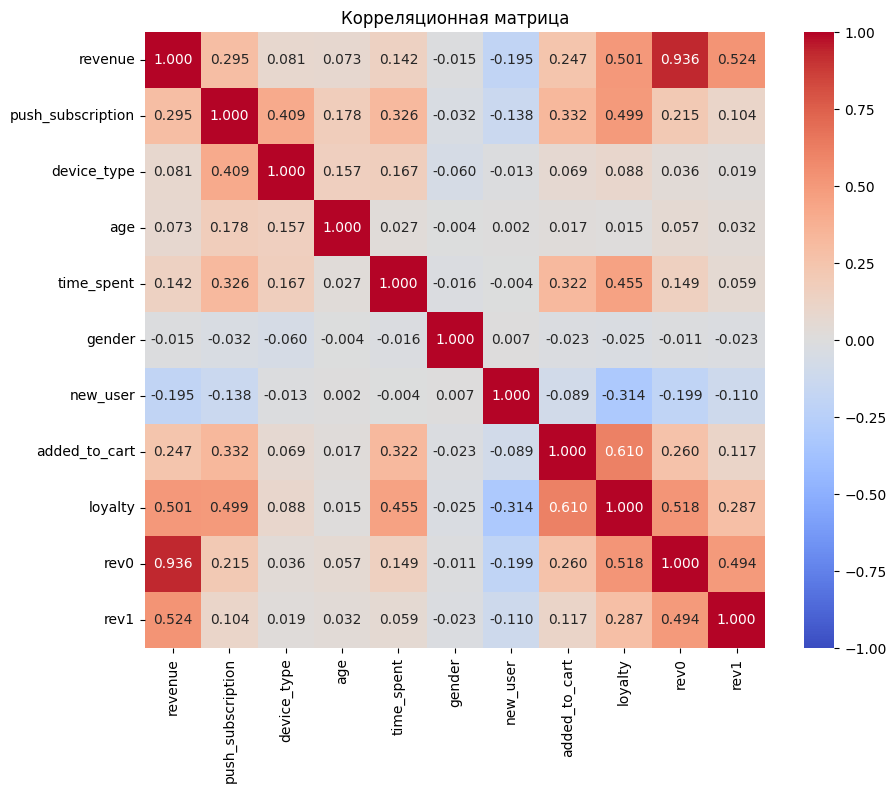

Непрерывные:
                mean      std     median      min        max
revenue     9765.605  700.517  10000.000  370.441  10000.000
age           35.903    8.854     35.531   18.018     64.686
time_spent    12.243   12.352      8.720    0.472    283.730
loyalty       61.312   16.459     61.000    3.000    100.000

Бинарные:
                   доля 1  число 1
push_subscription   0.450     4496
device_type         0.538     5385
gender              0.503     5035
new_user            0.298     2977
added_to_cart       0.497     4968


In [ ]:
continuous_vars = ['revenue', 'age', 'time_spent', 'loyalty']
binary_vars = ['push_subscription', 'device_type', 'gender', 'new_user', 'added_to_cart']

continuous_stats = data[continuous_vars].agg(['mean', 'std', 'median', 'min', 'max']).T
continuous_stats = continuous_stats.round(3)

binary_stats = pd.DataFrame({
    'доля 1': data[binary_vars].mean(),
    'число 1': data[binary_vars].sum()
}).round(3)

corr_matrix = data.corr().round(3)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt='.3f')
plt.title('Корреляционная матрица')
plt.show()

# Вывод описательных статистик
print("Непрерывные:")
print(continuous_stats)
print("\nБинарные:")
print(binary_stats)

Делим выборку на тест и трейн, где 25% относится к тесту.

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=123)

Приблизительно оценим адекватность дисперсий:

Видим, что разница не более 4 раз

In [ ]:
print(pd.DataFrame(data    = [np.var(error0),   np.var(g0),
                              np.var(g0_obs),   np.var(g0_unobs),
                              np.var(error1),   np.var(g1),
                              np.var(g1_obs),   np.var(g1_unobs)],
                   index   = ['Var(eps0)',     'Var(g0)',
                              'Var(g0_obs)',   'Var(g0_unobs)',
                              'Var(eps1)',     'Var(g1)',
                              'Var(g1_obs)',   'Var(g1_unobs)'],
                   columns = ['Оценка']))

                 Оценка
Var(eps0)      0.011574
Var(g0)        2.879953
Var(g0_obs)    0.023147
Var(g0_unobs)  2.708642
Var(eps1)      0.002495
Var(g1)        6.341340
Var(g1_obs)    0.035460
Var(g1_unobs)  6.094445


In [ ]:
print(np.var(index_device_type)) # еще одна проверка
print(np.var(prob_device_type))

0.012653642481776093
0.00813967139951902


Видим, что показатель выручки будет иметь смещенное распределение. Тем не менее, попробуем поработать с этим.

<Axes: ylabel='Density'>

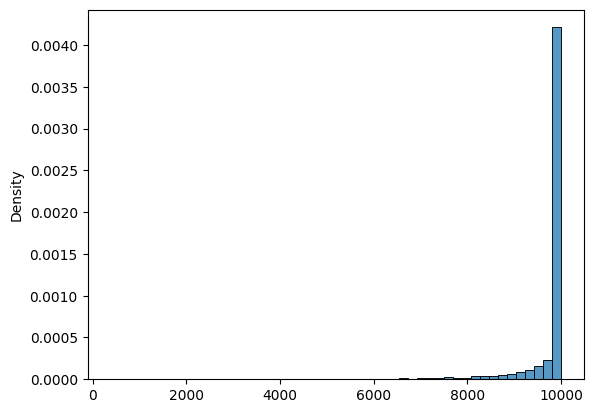

In [ ]:
# Посмотрим на распределение
seaborn.histplot(revenue,
                 stat = 'density',
                 label = "histogram",
                 bins = 50)

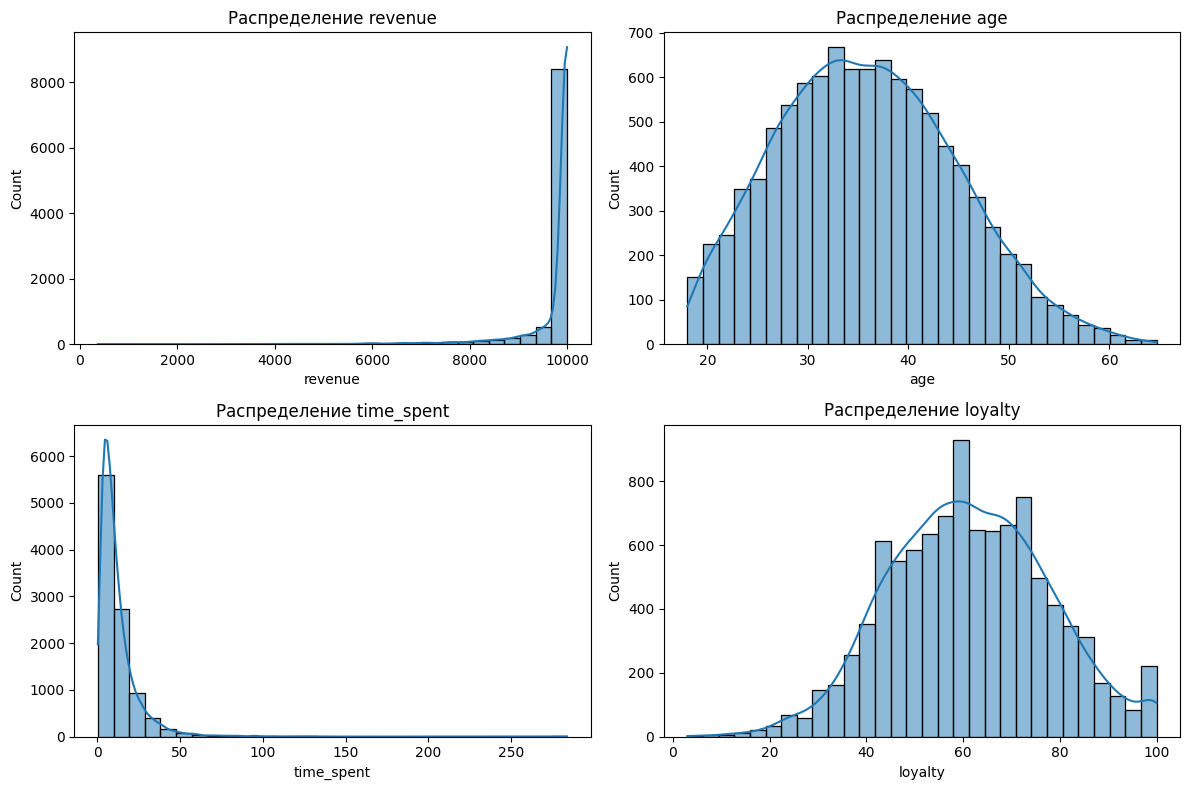

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, var in zip(axes.flatten(), continuous_vars):
    sns.histplot(data[var], bins=30, kde=True, ax=ax)
    ax.set_title(f'Распределение {var}')
plt.tight_layout()
plt.show()

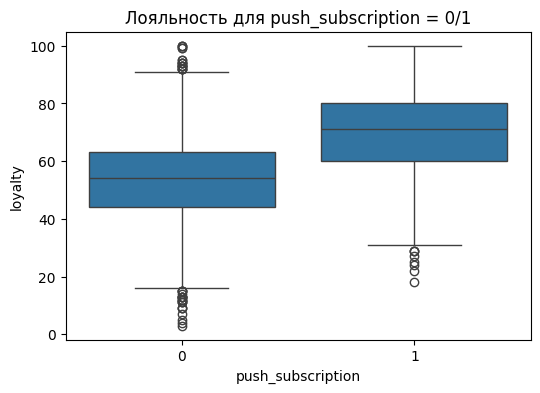

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='push_subscription', y='loyalty', data=data)
plt.title("Лояльность для push_subscription = 0/1")
plt.show()

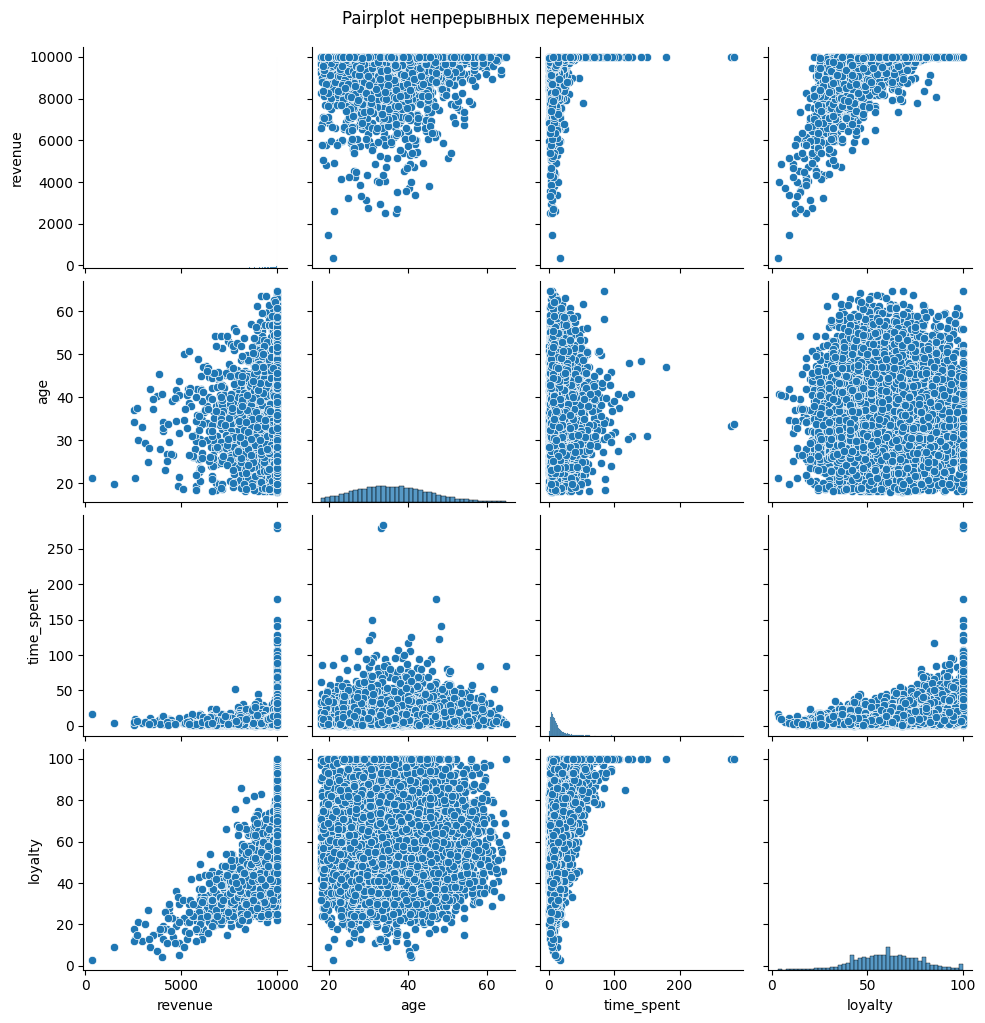

In [ ]:
sns.pairplot(data[continuous_vars])
plt.suptitle("Pairplot непрерывных переменных", y=1.02)
plt.show()

 # 5. Эффекты воздействия

In [ ]:
continuous_vars = ['revenue', 'age', 'time_spent', 'loyalty']
binary_vars = ['push_subscription', 'device_type', 'gender', 'new_user', 'added_to_cart']

Сгенерим большую выборку и возьмем семпл

In [ ]:
n = 5000000  # число наблюдений

np.random.seed(123)
gender_for_effects = np.random.binomial(1, 0.5, n)
new_user_for_effects = np.random.binomial(1, 0.3, n)

age_for_effects = truncnorm.rvs((18-35)/10, (65-35)/10, loc=35, scale=10, size=n)
index_device_type_for_effects = (
    0.3 * (
        0.6 * np.tanh((age_for_effects - 35) / 10)
        + 0.2 * (1 - gender_for_effects)
    )
)

prob_device_type_for_effects = norm.cdf(2 * index_device_type_for_effects)
prob_device_type_for_effects += np.random.normal(0, 0.02, size=prob_device_type_for_effects.shape)
prob_device_type_for_effects = np.clip(prob_device_type_for_effects, 0.01, 0.99)

device_type_for_effects = np.random.binomial(1, prob_device_type_for_effects)

time_spent_for_effects = lognorm.rvs(s=0.8, scale=np.exp(2 + 0.3 * device_type_for_effects))

logit_added_to_cart_for_effects = -1 + 0.1 * time_spent_for_effects - 0.5 * new_user_for_effects
prob_added_to_cart_for_effects = 1 / (1 + np.exp(-logit_added_to_cart_for_effects))
added_to_cart_for_effects = np.random.binomial(1, prob_added_to_cart_for_effects)

loyalty_raw_for_effects = t.rvs(size=n, df=8)
loyalty_for_effects = 50 + 0.5 * time_spent_for_effects - 10 * new_user_for_effects + 15 * added_to_cart_for_effects + 10 * loyalty_raw_for_effects
loyalty_for_effects = np.round(np.abs(loyalty_for_effects) + 1)
loyalty_for_effects = np.clip(loyalty_for_effects, 0, 100)

U_for_effects = np.random.uniform(0, 1, n)

intercept_for_effects = -9.18  # подобрано для коррелированности признаков
d_coef_for_effects = 2.20
age_coef_for_effects = 0.050
time_coef_for_effects = 0.030
loyalty_coef_for_effects = 0.090

logit_push_1_for_effects = (
    intercept_for_effects +
    d_coef_for_effects * 1 +
    age_coef_for_effects * age_for_effects +
    time_coef_for_effects * time_spent_for_effects +
    loyalty_coef_for_effects * loyalty_for_effects
)
logit_push_0_for_effects = (
    intercept_for_effects +
    d_coef_for_effects * 0 +
    age_coef_for_effects * age_for_effects +
    time_coef_for_effects * time_spent_for_effects +
    loyalty_coef_for_effects * loyalty_for_effects
)
prob_push_1_for_effects = 1 / (1 + np.exp(-logit_push_1_for_effects))
prob_push_0_for_effects = 1 / (1 + np.exp(-logit_push_0_for_effects))

Z1_for_effects = (prob_push_1_for_effects >= U_for_effects).astype(int)
Z0_for_effects = (prob_push_0_for_effects >= U_for_effects).astype(int)
push_subscription_for_effects = device_type_for_effects * Z1_for_effects + (1 - device_type_for_effects) * Z0_for_effects

phi_for_effects = 10

error0_for_effects = t.rvs(df=15, size=n) * 0.10
error1_for_effects = expon.rvs(scale=0.05, size=n) - 0.05

g0_obs_for_effects = 0.015 * age_for_effects + 0.005 * time_spent_for_effects - 0.02 * gender_for_effects - 0.03 * new_user_for_effects + 0.03 * added_to_cart_for_effects
g0_unobs_for_effects = 0.1 * loyalty_for_effects
g0_for_effects = -2 + g0_obs_for_effects + g0_unobs_for_effects + error0_for_effects

g1_obs_for_effects = 0.02 * age_for_effects + 0.001 * time_spent_for_effects - 0.04 * gender_for_effects - 0.02 * new_user_for_effects + 0.1 * added_to_cart_for_effects
g1_unobs_for_effects = 0.15 * loyalty_for_effects
g1_for_effects = -1.5 + g1_obs_for_effects + g1_unobs_for_effects + error1_for_effects

prob0_for_effects = 1 / (1 + np.exp(-g0_for_effects))
prob1_for_effects = 1 / (1 + np.exp(-g1_for_effects))
eps_for_effects = 1e-6
prob0_for_effects = np.clip(prob0_for_effects, eps_for_effects, 1 - eps_for_effects)
prob1_for_effects = np.clip(prob1_for_effects, eps_for_effects, 1 - eps_for_effects)

alpha0_for_effects = prob0_for_effects * phi_for_effects
beta0_for_effects = (1 - prob0_for_effects) * phi_for_effects
alpha1_for_effects = prob1_for_effects * phi_for_effects
beta1_for_effects = (1 - prob1_for_effects) * phi_for_effects

rev0_for_effects = 10000 * (beta.rvs(alpha0_for_effects, beta0_for_effects))
rev1_for_effects = 10000 * (beta.rvs(alpha1_for_effects, beta1_for_effects))

revenue_for_effects = rev1_for_effects * push_subscription_for_effects + rev0_for_effects * (1 - push_subscription_for_effects)

data_for_effects = pd.DataFrame({
    'revenue_for_effects': revenue_for_effects,
    'push_subscription_for_effects': push_subscription_for_effects,
    'device_type_for_effects': device_type_for_effects,
    'age_for_effects': age_for_effects,
    'time_spent_for_effects': time_spent_for_effects,
    'gender_for_effects': gender_for_effects,
    'new_user_for_effects': new_user_for_effects,
    'added_to_cart_for_effects': added_to_cart_for_effects,
    'loyalty_for_effects': loyalty_for_effects,
    'rev0_for_effects': rev0_for_effects,
    'rev1_for_effects': rev1_for_effects
})

sample_data_for_effects = data_for_effects.sample(n=10000, random_state=123)


### Задание 1

Для каждого пользователя \(i\) определим две потенциальные величины выручки:

$$
\begin{aligned}
Y_i(1) &= \text{значение выручки у пользователя} \ i \ \text{при получении пушей (т.е., если } W_i = 1\text{)} \\
Y_i(0) &= \text{значение выручки у пользователя} \ i \ \text{без пушей (т.е., если } W_i = 0 \text{)}
\end{aligned}
$$

Интерпретация:
Мы можем наблюдать выручку у пользователей, на которые влияет бинарный фактор - подписка на пуши. Этот фактор принимает лишь 2 значения (да или нет, 0 или 1), значит мы можем наблюдать лишь 2 исхода: выручка, когда пользователь подписан и выручка, когда пользователь не подписан. Поскольку переменная воздействия бинарная и принимает значения 0 или 1, она же и является индикатором того, подписан пользователь или нет. Тогда можем записать потенциальный исход в виде формулы ниже (логичность ее можно проверить, подставив 0 или 1 в индикатор).

Наблюдаем исход:  
$$
Y_i^{\text{obs}} = Y_i(W_i) = W_i \cdot Y_i(1) + (1 - W_i) \cdot Y_i(0)
$$
где $W_i \in \{0, 1\}$ — индикатор, была ли у пользователя подписка на пуши.


### Задание 2

Истинные эффекты воздействия считались бы так:
$$
ATE = E[Y |D = 1] − E[Y |D = 0]
$$


In [ ]:
sample_data_for_effects['CATE_for_effects'] = (
    sample_data_for_effects['rev1_for_effects'] - sample_data_for_effects['rev0_for_effects']
)

In [ ]:
ATE = (sample_data_for_effects['rev1_for_effects'] - sample_data_for_effects['rev0_for_effects']).mean()

#### Локальный средний эффект воздействия (LATE)
$$
LATE = E[Y(1) - Y(0) | D=1, Z=1] - E[Y(1) - Y(0) | D=0, Z=0]
$$
Где:
- \( D \) — индикатор (подписка, \( D=1 \) при подписке, \( D=0 \) без подписки).
- \( Z \) — инструментальная переменная (например, \( Z=1 \) для iOS, \( Z=0 \) для Android).
- LATE оценивает эффект для compliers.

#### Условный средний эффект воздействия (CATE)
$$
CATE(x) = E[Y(1) - Y(0) | X=x]
$$
Где:
- \( X \) — вектор переменных.
- \( CATE(x) \) — эффект для конкретной подгруппы.

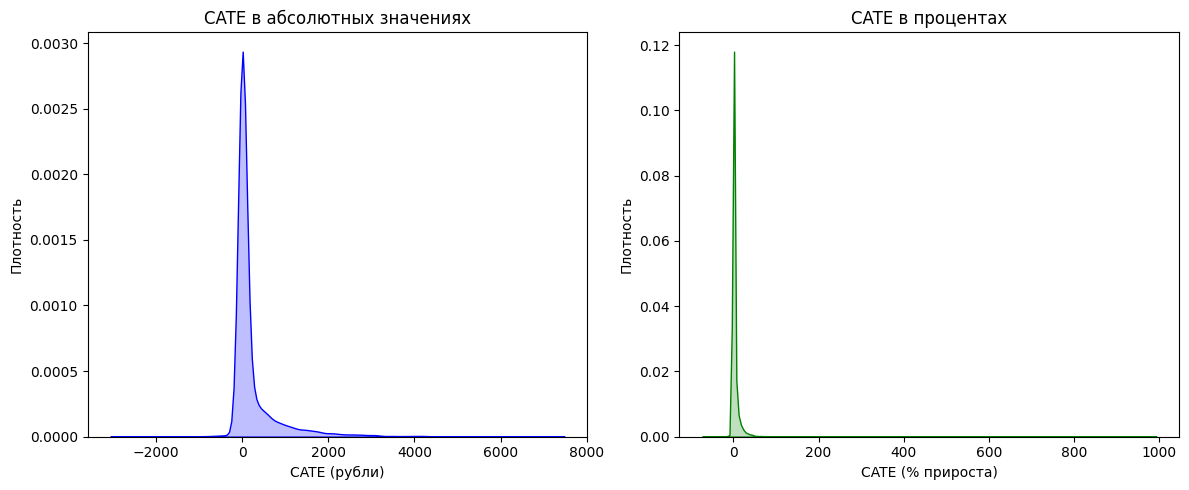

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.kdeplot(sample_data_for_effects['CATE_for_effects'], fill=True, color='blue')
plt.title('CATE в абсолютных значениях')
plt.xlabel('CATE (рубли)')
plt.ylabel('Плотность')

plt.subplot(1,2,2)
sample_data_for_effects['CATE_pct_for_effects'] = 100 * (
    (sample_data_for_effects['rev1_for_effects'] - sample_data_for_effects['rev0_for_effects'])
    / sample_data_for_effects['rev0_for_effects']
)
sns.kdeplot(sample_data_for_effects['CATE_pct_for_effects'], fill=True, color='green')
plt.title('CATE в процентах')
plt.xlabel('CATE (% прироста)')
plt.ylabel('Плотность')

plt.tight_layout()
plt.show()


In [ ]:
np.random.seed(123)
X_first_for_effects = add_constant(sample_data_for_effects[['device_type_for_effects', 'age_for_effects',
                                                            'time_spent_for_effects', 'loyalty_for_effects',
                                                            'gender_for_effects', 'new_user_for_effects', 'added_to_cart_for_effects']])
first_stage_for_effects = OLS(sample_data_for_effects['push_subscription_for_effects'], X_first_for_effects).fit()
sample_data_for_effects['push_subscription_pred_for_effects'] = first_stage_for_effects.fittedvalues
print("Первый этап 2SLS:")
print(first_stage_for_effects.summary())
f_stat_for_effects = first_stage_for_effects.fvalue
print(f"F-статистика: {f_stat_for_effects:.3f}")

X_second_for_effects = add_constant(sample_data_for_effects[['push_subscription_pred_for_effects', 'age_for_effects',
                                                             'time_spent_for_effects', 'loyalty_for_effects',
                                                             'gender_for_effects', 'new_user_for_effects', 'added_to_cart_for_effects']])
second_stage_for_effects = OLS(sample_data_for_effects['revenue_for_effects'], X_second_for_effects).fit()
LATE_for_effects = second_stage_for_effects.params['push_subscription_pred_for_effects']
print("\nВторой этап 2SLS:")
print(second_stage_for_effects.summary())


Первый этап 2SLS:
                                  OLS Regression Results                                 
Dep. Variable:     push_subscription_for_effects   R-squared:                       0.402
Model:                                       OLS   Adj. R-squared:                  0.402
Method:                            Least Squares   F-statistic:                     961.1
Date:                           Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                                   20:33:04   Log-Likelihood:                -4618.9
No. Observations:                          10000   AIC:                             9254.
Df Residuals:                               9992   BIC:                             9311.
Df Model:                                      7                                         
Covariance Type:                       nonrobust                                         
                                coef    std err          t      P>|t|      [0.025 

In [ ]:
results = pd.DataFrame({
    'Эффект': ['ATE', 'LATE'],
    'Значение': [ATE, LATE_for_effects]
}).round(3)
print(results)

  Эффект  Значение
0    ATE   236.073
1   LATE   182.340


#### Интерпретация результатов


ATE (236.073)

Средний эффект подписки на push-уведомления составляет 236.073 рублей увеличения стоимости покупки для всех пользователей. Возможно, что пуши стимулируют покупать чаще или на большую сумму.

LATE (182.340)


Локальный средний эффект для пользователей, чья подписка определяется типом устройства (compliers), составляет 182.340 рублей.
Для подгруппы compliers эффект подписки ниже. Это может быть связано с тем, что пользователи, чья подписка зависит от device_type, совершают менее дорогие покупки или реже реагируют на сами пуши.

CATE

График показывает ядерную оценку плотности с пиком около 0 и широким диапазоном значений. Заметим, что для некоторых пользователей подписка как снижает, так и увеличивает стоимость покупки.

### Задание 3

Рассчитаем ATE как разницу средних:




In [ ]:
data_1 = data

In [ ]:
ate_naive = data_1[data_1['push_subscription'] == 1]['revenue'].mean() - data_1[data_1['push_subscription'] == 0]['revenue'].mean()
print(f"Наивная оценка ATE: {ate_naive:.3f} (рубли)")

Наивная оценка ATE: 414.942 (рубли)


Вывод: наивная оценка эффекта воздействия переоценивает эффект, не учитывается эндгенность (например переменная о типе устройства).
- Имеется selection bias (например, может быть так, что на пуши чаще подписывается молодежь, чем люди старше, так как реже замечают их)
- Имеется ненаблюдаемая переменная лояльности (может лояльным клиентам нравятся пуши приложения)
- Такой подходи учитывает только наблюдаемые исходы

- Основная идея такая, что группы с включенными и выклеченными пушами могут сильно различаться по лдругим факторам, и тогда наивный подход будет давать смещенную оценку.


### Задание 4



In [ ]:
# Данные
y = data_1['revenue']
d = data_1['push_subscription']
X_full = data_1[['push_subscription', 'age', 'time_spent', 'loyalty',
                 'gender', 'new_user', 'added_to_cart', 'device_type']]
X = data_1[['age', 'time_spent', 'loyalty', 'gender', 'new_user', 'added_to_cart', 'device_type']]

# ----- 1. Метод наименьших квадратов (OLS) -----
X_ols = sm.add_constant(X_full)
ols_model = sm.OLS(y, X_ols).fit()
ate_ols = ols_model.params['push_subscription']
print(f"ATE по OLS: {ate_ols:.3f}")

# ----- 2. Условные математические ожидания -----
gd = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
# Обучим gd на всем датасете
gd.fit(X_full, y)

X1 = X_full.copy()
X1['push_subscription'] = 1
y1_pred = gd.predict(X1)

X0 = X_full.copy()
X0['push_subscription'] = 0
y0_pred = gd.predict(X0)

cate = y1_pred - y0_pred
ate_cate = np.mean(cate)
print(f"ATE по условному M(ожиданию): {ate_cate:.3f}")

# ----- 3. Взвешивание на обратные вероятности (IPW) -----
params = {'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}
lr = LogisticRegression(**params)
lr.fit(X, d)
p = lr.predict_proba(X)[:, 1]
p = np.clip(p, 1e-3, 1-1e-3)

ate_ipw = np.mean(d * y / p - (1 - d) * y / (1 - p))
print(f"ATE по IPW: {ate_ipw:.3f}")

# ----- 4. Метод двойной устойчивости (Double Robust, DR) -----
# Предсказания для DR
X1_dr = X_full.copy()
X1_dr['push_subscription'] = 1
mu1 = gd.predict(X1_dr)
X0_dr = X_full.copy()
X0_dr['push_subscription'] = 0
mu0 = gd.predict(X0_dr)

dr = (mu1 - mu0) + d * (y - mu1) / p - (1 - d) * (y - mu0) / (1 - p)
ate_dr = np.mean(dr)
print(f"ATE по Double Robust: {ate_dr:.3f}")

# ----- 5. Двойное машинное обучение (DoubleML) -----
df_dml = pd.concat([y, d, X], axis=1)
data_dml = dml.DoubleMLData(df_dml,
                            y_col='revenue',
                            d_cols='push_subscription')

ml_g = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
ml_m = LogisticRegression(**params)
dml_plr = dml.DoubleMLPLR(data_dml, ml_g, ml_m, n_folds=3)
dml_plr.fit()
ate_dml = dml_plr.coef[0]
print(f"ATE по DoubleML: {ate_dml:.3f}")

ATE по OLS: 73.922
ATE по условному M(ожиданию): 205.740
ATE по IPW: -51.406
ATE по Double Robust: 230.535


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ATE по DoubleML: 166.293


### Задание 5

DML без инструментальной переменной:

In [ ]:
y = data_1['revenue']
d = data_1['push_subscription']
z = data_1['device_type']
X = data_1[['age', 'time_spent', 'gender', 'new_user', 'added_to_cart']]
np.random.seed(123)

df = pd.concat([y, d, X], axis=1)

data_dml = dml.DoubleMLData(df, y_col='revenue', d_cols='push_subscription')

ml_g = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=123)
ml_m = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=123)

dml_plr = dml.DoubleMLPLR(data_dml, ml_g, ml_m, n_folds=5)  # если binary treatment, можно и DoubleMLIRM
dml_plr.fit()
print(f"ATE, DoubleML без IV: {dml_plr.coef[0]:.3f} (95% CI: [{dml_plr.confint().iloc[0,0]:.3f}, {dml_plr.confint().iloc[0,1]:.3f}])")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ATE, DoubleML без IV: 291.273 (95% CI: [271.079, 311.467])


 DML с инструментальной переменной:

In [ ]:
df_iv = pd.concat([y, d, z, X], axis=1)
np.random.seed(123)

data_iv = dml.DoubleMLData(
    df_iv,
    y_col='revenue',
    d_cols='push_subscription',
    z_cols='device_type'
)

ml_g = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=123)
ml_m = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=123)
ml_r = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=123)

dml_pliv = dml.DoubleMLPLIV(data_iv, ml_g, ml_m, ml_r, n_folds=5)
dml_pliv.fit()
print(f"LATE, DoubleML с IV: {dml_pliv.coef[0]:.3f} (95% CI: [{dml_pliv.confint().iloc[0,0]:.3f}, {dml_pliv.confint().iloc[0,1]:.3f}])")

/usr/local/lib/python3.11/dist-packages/doubleml/double_ml.py:974: UserWarning: Learner provided for ml_m is probably invalid: RandomForestClassifier(max_depth=5, random_state=123) is (probably) no regressor.
  warnings.warn(warn_msg_prefix + f"{str(learner)} is (probably) no regressor.")
/usr/local/lib/python3.11/dist-packages/doubleml/double_ml.py:974: UserWarning: Learner provided for ml_r is probably invalid: RandomForestClassifier(max_depth=5, random_state=123) is (probably) no regressor.
  warnings.warn(warn_msg_prefix + f"{str(learner)} is (probably) no regressor.")
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist

LATE, DoubleML с IV: 83.682 (95% CI: [13.214, 154.149])


In [ ]:
results = pd.DataFrame({
    "Метод": [
        "DML без инструмента (ATE)",
        "DML с инструментом (LATE)"
    ],
    "Оценка эффекта": [
        dml_plr.coef[0],
        dml_pliv.coef[0]
    ],
    "95% ДИ (нижняя граница)": [
        dml_plr.confint().iloc[0, 0],
        dml_pliv.confint().iloc[0, 0]
    ],
    "95% ДИ (верхняя граница)": [
        dml_plr.confint().iloc[0, 1],
        dml_pliv.confint().iloc[0, 1]
    ]
})

results = results.round(3)
print(results)


                       Метод  Оценка эффекта  95% ДИ (нижняя граница)  \
0  DML без инструмента (ATE)         291.273                  271.079   
1  DML с инструментом (LATE)          83.682                   13.214   

   95% ДИ (верхняя граница)  
0                   311.467  
1                   154.149  


#### Вывод

**1. Средний эффект воздействия (ATE, DoubleML без инструмента):**  
Оценка эффекта составляет 291.273 рубля (95% ДИ: [271.079; 311.467]). Это означает средний прирост выручки от push-подписок для всей совокупности пользователей. Измеряет влияние push-подписки на выручку для всех пользователей, вне зависимости от причин и обстоятельств, по которым они подписались. Как ранее упоминали, оценка может быть смещенной.

**2. Локальный средний эффект воздействия (LATE, DoubleML с инструментом):**  
Эффект среди пользователей, чьё решение о подписке на пуши меняется под влиянием типа устройства — составляет 83.682 рублей (95% ДИ: [13.214; 154.149]). Эффект статистически значим, но существенно меньше, чем ATE. Это, по сути, эффект именно от изменения внешнего фактора (автоматически подписывают на пуши или нет), а не от самоотбора.

ATE сильно больше LATE в этом пункте, что может говорить о том, что эффект от пушей может быть в большей степень определен другими характеристиками пользователей (эффект более заметен из-за тех, кто подписался бы на пуши в любом случае).

Экономическая интерпретация:

- **LATE** показывает, что эффект того, что мы будем активнее подписывать на пуши владельцев айфонов, будет менее значимым, чем на всей выборке.  
- Прирост стоимости покупки хоть и значим статистически, но его экономическая значимость для бизнеса может быть под вопросом. Это сигнал, что вложения в разработку вовлекающих фичей для IOS могут иметь ограниченную отдачу. Необходимо оценить рентабельность таких инвестиций.
- Эффект значительно выше, если подписывать на пуши уже вовлеченных пользователей (в перспективе можно выявить через прокси метрики).

### Задание 6

In [ ]:
X = data_1[['age', 'time_spent', 'gender', 'new_user', 'added_to_cart']]
T = data_1['push_subscription']
y = data_1['revenue']

МНК:

In [ ]:
ols_treat = LinearRegression().fit(X[T == 1], y[T == 1])
mu1_hat = ols_treat.predict(X)

ols_control = LinearRegression().fit(X[T == 0], y[T == 0])
mu0_hat = ols_control.predict(X)

cate_lm = mu1_hat - mu0_hat

ate_lm = cate_lm.mean()
print(f"ATE_LS (по МНК): {ate_lm:.3f}")

ATE_LS (по МНК): 285.533


S-learner:

In [ ]:
X_S = pd.concat([X, T], axis=1)
rf_s = RandomForestRegressor(max_depth=5, random_state=42)
rf_s.fit(X_S, y)

# CATE(X) = pred(X, T=1) - pred(X, T=0)
X1 = X.copy()
X1['push_subscription'] = 1
X0 = X.copy()
X0['push_subscription'] = 0

cate_slearner = rf_s.predict(X1) - rf_s.predict(X0)
print(f"CATE (S-learner, mean): {cate_slearner.mean():.3f}")

CATE (S-learner, mean): 341.123


T-learner:

In [ ]:
gbr_treat = GradientBoostingRegressor(max_depth=3, n_estimators=100, random_state=42)
gbr_treat.fit(X[T == 1], y[T == 1])
mu1_hat = gbr_treat.predict(X)

rf_control = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)
rf_control.fit(X[T == 0], y[T == 0])
mu0_hat = rf_control.predict(X)

cate_tlearner = mu1_hat - mu0_hat

ate_tlearner = np.mean(cate_tlearner)
print(f"T-learner: ATE = {ate_tlearner:.3f}")

T-learner: ATE = 340.845


Метод трансформации классов

In [ ]:
rf_ps = RandomForestClassifier(max_depth=5, random_state=42)
rf_ps.fit(X, T)
p_hat = rf_ps.predict_proba(X)[:, 1]
p_hat = np.clip(p_hat, 1e-3, 1-1e-3)

y_star = T * y / p_hat - (1 - T) * y / (1 - p_hat)

rf_cate = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)
rf_cate.fit(X, y_star)
cate_ipw = rf_cate.predict(X)
ate_ipw = cate_ipw.mean()

print(f"Class Transformation (IPW): ATE = {ate_ipw:.3f}")

Class Transformation (IPW): ATE = 362.993


X-learner:

In [ ]:
rf1 = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)
rf0 = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)
rf1.fit(X[T == 1], y[T == 1])
rf0.fit(X[T == 0], y[T == 0])
mu1 = rf1.predict(X)
mu0 = rf0.predict(X)

D1 = (y[T == 1] - mu0[T == 1])  # для treated
D0 = (mu1[T == 0] - y[T == 0])  # для control

rf_D1 = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)
rf_D0 = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)
rf_D1.fit(X[T == 1], D1)
rf_D0.fit(X[T == 0], D0)

rf_p = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42)
rf_p.fit(X, T)
p_hat = rf_p.predict_proba(X)[:, 1]

tau_control = rf_D0.predict(X)
tau_treated = rf_D1.predict(X)
cate_xlearner = p_hat * tau_control + (1 - p_hat) * tau_treated
ate_xlearner = cate_xlearner.mean()

print(f"X-learner: ATE = {ate_xlearner:.3f}")

X-learner: ATE = 334.723


In [ ]:
results_cate = pd.DataFrame({
    "Метод": [
        "OLS (T-learner на МНК)",
        "S-learner",
        "T-learner (ML)",
        "Class transformation",
        "X-learner"
    ],
    "CATE (mean)": [
        cate_lm.mean() if 'ate_lm' in locals() else np.nan,
        cate_slearner.mean() if 'cate_slearner' in locals() else np.nan,
        cate_tlearner.mean() if 'cate_tlearner' in locals() else np.nan,
        cate_ipw.mean() if 'cate_ipw' in locals() else np.nan,
        cate_xlearner.mean() if 'cate_xlearner' in locals() else np.nan
    ]
})

print(results_cate)

                    Метод  CATE (mean)
0  OLS (T-learner на МНК)   285.532743
1               S-learner   341.122505
2          T-learner (ML)   340.844524
3    Class transformation   362.993161
4               X-learner   334.723042


#### Вывод

- ML-методы (S-learner, T-learner, X-learner) дают более высокие оценки CATE, чем простая модель ОLS, что говорит о наличии нелинейных связей между признаками и эффектом воздействия.
- X-learner и T-learner выдают близкие результаты, модели устойчивы.
- Трансформация классов даёт максимально низкий средний эффект, S-learner и X-learner — умеренно высокие, но все превышают OLS.

Мотивация для X-learner

- X-learner нужен, если эффект воздействия зависит от индивидуальных характеристик и есть дисбаланс между treated и control-группами. Такое часто бывает в реальной жизни.
- Метод позволяет точнее выделить, для кого эффект максимален, поскольку строится отдельно на каждой группе.

CATE в практике

- Использовать индивидуальные оценки для точечной проработки: пуши отправлять тем, для кого прогнозируется наибольший отклик.
- Сегментировать аудиторию (далее настраиваемые рекламные кампании, программы лояльности, механики удержания и тп).

Методы, способные учитывать индивидуальные эффекты (например X-learner), более информативны для принятия решений, чем усреднённые оценки. Это позволяет фокусироваться на отдельных сегментах и повышать эффекты от интервенций.


### Задание 7

Оценка по истинным CATE

In [ ]:
cate_true = data_1['rev1'] - data_1['rev0']

results_cate["MSE с истиной"] = [
    np.mean((cate_lm - cate_true)**2) if 'cate_lm' in locals() else np.nan,
    np.mean((cate_slearner - cate_true)**2) if 'cate_slearner' in locals() else np.nan,
    np.mean((cate_tlearner - cate_true)**2) if 'cate_tlearner' in locals() else np.nan,
    np.mean((cate_ipw - cate_true)**2) if 'cate_ipw' in locals() else np.nan,
    np.mean((cate_xlearner - cate_true)**2) if 'cate_xlearner' in locals() else np.nan
]

Сравнение по прогнозной точности

In [ ]:
idx_train, idx_test = train_test_split(range(len(X)), test_size=0.2, random_state=42)

def cate_pred_err(cate_pred, idx=idx_test):
    return np.mean((cate_pred[idx] - cate_true[idx])**2)

results_cate["Test MSE (with true CATE)"] = [
    cate_pred_err(cate_lm),
    cate_pred_err(cate_slearner),
    cate_pred_err(cate_tlearner),
    cate_pred_err(cate_ipw),
    cate_pred_err(cate_xlearner)
]

Выбор по логике псевдоисхода

In [ ]:
results_cate["MSE (vs псевдоисход)"] = [
    mean_squared_error(y_star, cate_lm),
    mean_squared_error(y_star, cate_slearner),
    mean_squared_error(y_star, cate_tlearner),
    mean_squared_error(y_star, cate_ipw),
    mean_squared_error(y_star, cate_xlearner)
]

In [ ]:
results_cate

,Метод,CATE (mean),MSE с истиной,Test MSE (with true CATE),MSE (vs псевдоисход)
0,OLS (T-learner на МНК),285.532743,3.991999e+05,4.054951e+05,4.474717e+08
1,S-learner,341.122505,3.921790e+05,3.937103e+05,4.465164e+08
2,T-learner (ML),340.844524,3.856456e+05,3.921187e+05,4.465084e+08
3,Class transformation,362.993161,6.112336e+06,6.418034e+06,4.327555e+08
4,X-learner,334.723042,3.954972e+05,3.988193e+05,4.464929e+08


Выбор наилучшей модели:

1) **Сравнение с истинными CATE**: меньшее отклонение от истины показывает T-learner (ML), за ним следуют S-learner и X-learner. OLS демонстрирует наихудший результат среди ML-методов.

2) **По тестовой выборке (Test MSE)**: лучшие результаты показывает также T-learner (ML), затем S-learner и X-learner.

3) **По псевдоисходам**: наименьшую ошибку демонстрирует классовая трансформация, в то время как другие методы имеют очень близкие значения. Это может быть спецификой метрики, но отличие существенно.

**Оптимальный выбор** — T-learner (ML), так как он показывает наилучшие результаты как по MSE с истиной, так и по тестовому MSE. X-learner и S-learner также демонстрируют высокую точность и могут быть хорошими альтернативами.

**Классовая трансформация** показывает наихудшие результаты по MSE с истиной и Test MSE, что на порядок хуже других методов, несмотря на хорошие показатели по метрике псевдоисходов.

**OLS** уступает машинным методам по точности, но может быть предпочтительным, если важна интерпретируемость результатов и если зависимости между факторами и эффектом близки к линейным.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### Задание 8


In [ ]:
# ----- Худшие модели -----
# Классификатор: KNN с указанными параметрами
params_knn = {'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 9,
 'p': 1,
 'weights': 'distance'}
knn = KNeighborsClassifier(**params_knn)

# Регрессор: LinearRegression
lr_reg = LinearRegression()

# ----- 1. Метод наименьших квадратов (OLS) с худшей моделью -----
X_ols = sm.add_constant(X_full)
ols_model_worst = sm.OLS(y, X_ols).fit()
ate_ols_worst = ols_model_worst.params['push_subscription']
print(f"ATE по OLS (худшая модель): {ate_ols_worst:.3f}")

# ----- 2. Условные математические ожидания с худшей моделью -----
# Обучаем LinearRegression на всем датасете
lr_reg.fit(X_full, y)

X1 = X_full.copy()
X1['push_subscription'] = 1
y1_pred_worst = lr_reg.predict(X1)

X0 = X_full.copy()
X0['push_subscription'] = 0
y0_pred_worst = lr_reg.predict(X0)

cate_worst = y1_pred_worst - y0_pred_worst
ate_cate_worst = np.mean(cate_worst)
print(f"ATE по условному M(ожиданию) (худшая модель): {ate_cate_worst:.3f}")

# ----- 3. Взвешивание на обратные вероятности (IPW) с худшей моделью -----
knn.fit(X, d)
p_worst = knn.predict_proba(X)[:, 1]
p_worst = np.clip(p_worst, 1e-3, 1-1e-3)  # Избегаем 0 и 1

ate_ipw_worst = np.mean(d * y / p_worst - (1 - d) * y / (1 - p_worst))
print(f"ATE по IPW (худшая модель): {ate_ipw_worst:.3f}")

# ----- 4. Метод двойной устойчивости (Double Robust, DR) с худшими моделями -----
# Предсказания для DR
X1_dr = X_full.copy()
X1_dr['push_subscription'] = 1
mu1_worst = lr_reg.predict(X1_dr)
X0_dr = X_full.copy()
X0_dr['push_subscription'] = 0
mu0_worst = lr_reg.predict(X0_dr)

dr_worst = (mu1_worst - mu0_worst) + d * (y - mu1_worst) / p_worst - (1 - d) * (y - mu0_worst) / (1 - p_worst)
ate_dr_worst = np.mean(dr_worst)
print(f"ATE по Double Robust (худшие модели): {ate_dr_worst:.3f}")

# ----- 5. Двойное машинное обучение (DoubleML) с худшими моделями -----
df_dml = pd.concat([y, d, X], axis=1)
data_dml = dml.DoubleMLData(df_dml,
                            y_col='revenue',
                            d_cols='push_subscription')

# Используем худшие модели
dml_plr_worst = dml.DoubleMLPLR(data_dml, lr_reg, knn, n_folds=3)
dml_plr_worst.fit()
ate_dml_worst = dml_plr_worst.coef[0]
print(f"ATE по DoubleML (худшие модели): {ate_dml_worst:.3f}")

ATE по OLS (худшая модель): 73.922
ATE по условному M(ожиданию) (худшая модель): 73.922
ATE по IPW (худшая модель): -779.790
ATE по Double Robust (худшие модели): 73.922


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ATE по DoubleML (худшие модели): 250.000


/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:194: UserWarning: Propensity predictions from learner KNeighborsClassifier(n_neighbors=9, p=1, weights='distance') for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(


 # 4. Регрессия


В каждом из заданий, если не сказано иного, необходимо использовать хотя бы 3 (на ваш выбор) из следующих методов: случайный лес, метод наименьших квадратов, метод ближайших соседей и градиентный бустинг.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### Задание 1

Отберите признаки, которые могут быть полезны при прогнозировании целевой (зависимой) переменной. Не включайте в число этих признаков переменную воздействия. Содержательно обоснуйте выбор признаков.

In [ ]:
selected_features = ['time_spent', 'loyalty', 'age', 'device_type', 'added_to_cart']

# Формируем обучающую и тестовую выборки из ранее разделённых данных
X_train = train_data[selected_features]
y_train = train_data['revenue'] * 100  # Целевая переменная: сумма покупки
X_test = test_data[selected_features]
y_test = test_data['revenue'] * 100


Целевая переменная и выбранные признаки (без переменной воздействия):

Инициализация моделей:

In [ ]:
models = {
    "OLS": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}


Результат:

In [ ]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

    results.append({
        "Model": name,
        "RMSE (Train)": rmse_train,
        "RMSE (Test)": rmse_test,
        "MAPE (Train)": mape_train,
        "MAPE (Test)": mape_test
    })

In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

               Model  RMSE (Train)   RMSE (Test)  MAPE (Train)  MAPE (Test)
0                OLS  59434.434034  60802.755255      0.044860     0.043530
1      Random Forest  17055.268068  47693.548325      0.009478     0.025356
2  Gradient Boosting  38992.881316  45090.495784      0.021460     0.024743
3                KNN  37865.865281  50579.041259      0.020840     0.026613


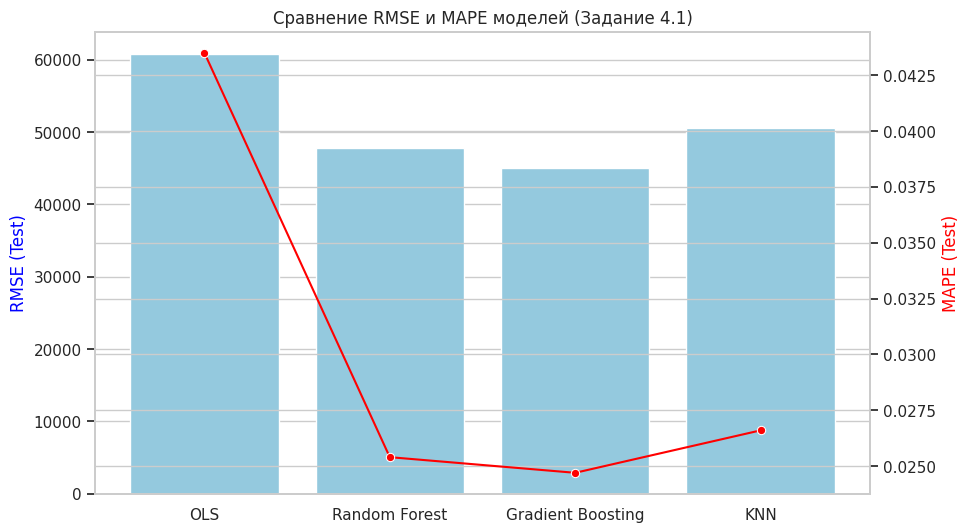

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


models = ['OLS', 'Random Forest', 'Gradient Boosting', 'KNN']
rmse_test = [60802.76, 47734.98, 45090.50, 50579.04]
mape_test = [0.0435, 0.0254, 0.0247, 0.0266]

fig, ax1 = plt.subplots()
sns.barplot(x=models, y=rmse_test, color="skyblue", ax=ax1)
ax1.set_ylabel("RMSE (Test)", color="blue")
ax1.set_title("Сравнение RMSE и MAPE моделей (Задание 4.1)")

ax2 = ax1.twinx()
sns.lineplot(x=models, y=mape_test, marker="o", color="red", ax=ax2)
ax2.set_ylabel("MAPE (Test)", color="red")
plt.show()

### Интерпретация результатов
Linear Regression (OLS):
Простая модель, плохо справляется с нелинейностями.
RMSE и MAPE заметно выше по сравнению с другими методами.
Random Forest:
Лучший результат по MAPE (наименьшая средняя процентная ошибка).
Переобучение выражено умеренно (Train RMSE ≪ Test RMSE), но всё же присутствует.
Gradient Boosting:
Лучший RMSE на тестовой выборке — значит, хорошо предсказывает экстремальные значения.
MAPE — почти такой же, как у Random Forest.
KNN:
Уступает ансамблевым методам по точности.
MAPE и RMSE хуже, вероятно, из-за чувствительности метода к масштабу и шуму в данных.

### Выводы:
Для задачи прогнозирования суммы покупки:

Лучшие результаты показывает ансамблевый метод — Gradient Boosting, особенно по RMSE на тесте.
Random Forest — лидер по процентной точности (MAPE), то есть приоритетен, если важна относительная ошибка.

### Задание 2
Выберите произвольные значения гиперпараметров, а затем оцените и сравните (между методами) точность прогнозов с помощью RMSE и MAPE:
- на обучающей выборке.
- на тестовой выборке.
- с помощью кросс-валидации (используйте только обучающую выборку).
Проинтерпретируйте полученные результаты.


Инициализация моделей с произвольными гиперпараметрами

In [ ]:
rf = RandomForestRegressor(n_estimators=150, max_depth=6, random_state=42)
gb = GradientBoostingRegressor(n_estimators=120, learning_rate=0.08, max_depth=4, random_state=42)
knn = KNeighborsRegressor(n_neighbors=7)


Кросс-валидация

In [ ]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=120, max_depth=6, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=110, learning_rate=0.07, max_depth=4, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=6),
    "OLS": LinearRegression()
}

In [ ]:
results = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

    # Кросс-валидация по RMSE
    neg_mse_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
    rmse_cv = np.mean(np.sqrt(-neg_mse_scores))

    results.append({
        "Model": name,
        "RMSE (Train)": rmse_train,
        "RMSE (Test)": rmse_test,
        "MAPE (Train)": mape_train,
        "MAPE (Test)": mape_test,
        "RMSE (CV)": rmse_cv
    })

In [ ]:
print(results)

[{'Model': 'Random Forest', 'RMSE (Train)': np.float64(38013.44292505737), 'RMSE (Test)': np.float64(45634.779032621285), 'MAPE (Train)': 0.021158044280908925, 'MAPE (Test)': 0.024681003235065845, 'RMSE (CV)': np.float64(43984.14804804932)}, {'Model': 'Gradient Boosting', 'RMSE (Train)': np.float64(36926.906688460236), 'RMSE (Test)': np.float64(45564.243043801274), 'MAPE (Train)': 0.020261174784499465, 'MAPE (Test)': 0.024737221242483936, 'RMSE (CV)': np.float64(44473.74248134484)}, {'Model': 'KNN', 'RMSE (Train)': np.float64(38832.06488579656), 'RMSE (Test)': np.float64(49973.575451339544), 'MAPE (Train)': 0.021536538001861633, 'MAPE (Test)': 0.026511941343440922, 'RMSE (CV)': np.float64(46176.047999583665)}, {'Model': 'OLS', 'RMSE (Train)': np.float64(59434.43403387334), 'RMSE (Test)': np.float64(60802.75525529468), 'MAPE (Train)': 0.04485993577609929, 'MAPE (Test)': 0.0435304490048386, 'RMSE (CV)': np.float64(59320.10077940572)}]


### Интерпретация результатов:

Лучшими моделями по точности на тестовой выборке оказались ансамблевые методы — **Random Forest** и **Gradient Boosting**. Обе модели показали низкие значения RMSE и MAPE, при этом не склонны к сильному переобучению.

**Gradient Boosting** продемонстрировал наименьшую ошибку RMSE на обучающей выборке, что свидетельствует о высокой гибкости модели. Но сопровождается немного более высокой ошибкой в кросс-валидации, указывая на потенциальную чувствительность к переобучению.

**Random Forest** показал лучшую устойчивость, продемонстрировав минимальное RMSE при кросс-валидации. Это делает его надёжным выбором при работе с новыми данными.

**Метод ближайших соседей (KNN)** - уступает ансамблевым моделям по всем метрикам. Особенно чувствителен к размерности данных и масштабу признаков.

**Линейная регрессия (OLS)** показала себя наихудшим образом. Высокие значения RMSE и MAPE указывают на то, что она не способна уловить сложные, нелинейные зависимости в данных.

### Выводы:

Лучше использовать **Random Forest** как сбалансированная по точности и устойчивости модель.

**Gradient Boosting** может использоваться, если необходимо достичь максимально точного прогноза при возможности дополнительной настройки гиперпараметров и контроля переобучения.

### Задание 3
Для каждого метода с помощью кросс-валидации на обучающей выборке под- берите оптимальные значения гиперпараметров (тюнинг). В качестве критерия качества используйте RMSE. Результат представьте в форме таблицы, в которой для каждого метода должны быть указаны:
- изначальные и подобранные значения гиперпараметров.
- кросс-валидационное значение RMSE на обучающей выборке с исходными и подобранными значениями гиперпараметров.
- значение RMSE на тестовой выборке с исходными и подобранными значе- ниями гиперпараметров.

Проинтерпретируйте полученные результаты.


In [ ]:
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, None]}
param_grid_gb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
param_grid_knn = {'n_neighbors': [3, 5, 7]}

models_grid = {
    'Random Forest': (RandomForestRegressor(random_state=42), param_grid_rf),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), param_grid_gb),
    'KNN': (KNeighborsRegressor(), param_grid_knn)
}


In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

In [ ]:
for name, (model, param_grid) in models_grid.items():
    # Изначальные параметры (первые из словаря)
    init_params = {key: val[0] for key, val in param_grid.items()}
    model.set_params(**init_params)
    model.fit(X_train, y_train)

    y_pred_base = model.predict(X_test)
    rmse_test_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
    rmse_cv_base = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)))

    # GridSearchCV
    grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    y_pred_tuned = best_model.predict(X_test)
    rmse_test_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    rmse_cv_tuned = np.mean(np.sqrt(-cross_val_score(best_model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)))

    results.append({
        'Model': name,
        'Initial Params': init_params,
        'Best Params': best_params,
        'CV RMSE (Initial)': rmse_cv_base,
        'CV RMSE (Tuned)': rmse_cv_tuned,
        'Test RMSE (Initial)': rmse_test_base,
        'Test RMSE (Tuned)': rmse_test_tuned
    })

In [ ]:
tuning_df_final = pd.DataFrame(results)
tuning_df_final

,Model,Initial Params,Best Params,CV RMSE (Initial),CV RMSE (Tuned),Test RMSE (Initial),Test RMSE (Tuned)
0,Random Forest,"{'n_estimators': 50, 'max_depth': 3}","{'max_depth': 5, 'n_estimators': 50}",44100.002049,43699.172884,45605.936469,45271.732825
1,Gradient Boosting,"{'n_estimators': 50, 'learning_rate': 0.01}","{'learning_rate': 0.1, 'n_estimators': 50}",54961.448423,43936.910977,56748.194006,44969.816436
2,KNN,{'n_neighbors': 3},{'n_neighbors': 7},48914.825254,45774.215433,52323.673985,49159.548763


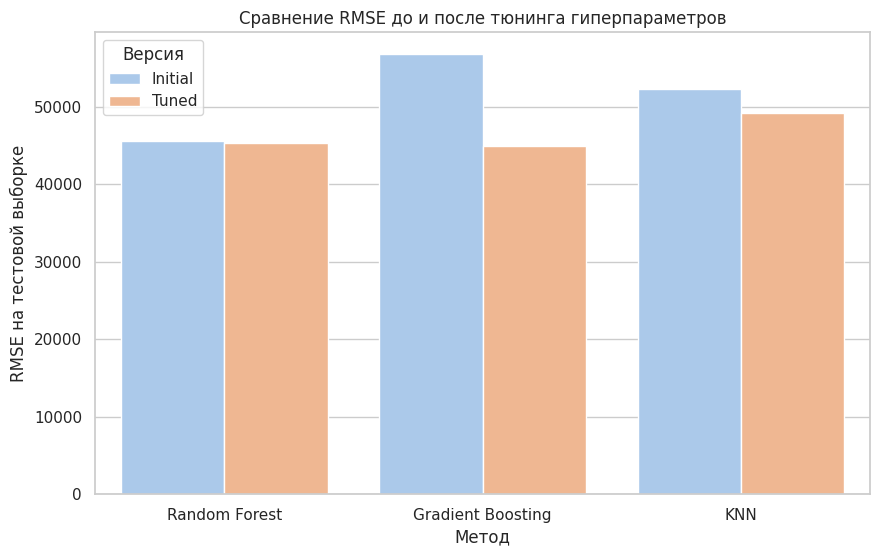

In [ ]:
methods = ['Random Forest', 'Gradient Boosting', 'KNN']
rmse_initial = [45605.94, 56748.19, 52323.67]
rmse_tuned = [45271.73, 44969.82, 49159.55]

df_tuning = pd.DataFrame({
    'Метод': methods * 2,
    'RMSE': rmse_initial + rmse_tuned,
    'Версия': ['Initial'] * 3 + ['Tuned'] * 3
})

plt.figure()
sns.barplot(data=df_tuning, x="Метод", y="RMSE", hue="Версия", palette="pastel")
plt.title("Сравнение RMSE до и после тюнинга гиперпараметров")
plt.ylabel("RMSE на тестовой выборке")
plt.show()

### Интерпретация результатов

**1. Random Forest**

Изначальные параметры: n_estimators = 50, max_depth = 3

Подобранные параметры: n_estimators = 50, max_depth = 5

После увеличения глубины деревьев наблюдается небольшое, но устойчивое снижение RMSE как на кросс-валидации, так и на тестовой выборке.

**Вывод:** начальные параметры уже были близки к оптимальным, но увеличение глубины позволило учесть большее количество взаимодействий между признаками.


**2. Gradient Boosting**

Изначальные параметры: n_estimators = 50, learning_rate = 0.01

Подобранные параметры: n_estimators = 50, learning_rate = 0.1

После настройки обеспечили наибольшее снижение ошибки: RMSE на тестовой выборке уменьшилось более чем на 11 000.

**Вывод:** изначальный learning rate был слишком низким, что приводило к недообучению. Оптимизация значительно повысила точность модели.

**3. K-Nearest Neighbors (KNN)**

Изначальные параметры: n_neighbors = 3

Подобранные параметры: n_neighbors = 7

Увеличение числа соседей позволило сгладить влияние шумов и улучшить обобщающую способность.

**Вывод:** подобранные параметры снизили как кросс-валидационную, так и тестовую ошибку, улучшив устойчивость модели.


### Выводы:
- Все модели продемонстрировали улучшение качества прогнозирования после настройки гиперпараметров.
- Наибольший эффект наблюдается у Gradient Boosting, где изначально модель была недообучена.
- Подбор гиперпараметров подтверждает свою важность для повышения точности и устойчивости моделей на новых данных.

Повышенная сложность: подберите на обучающей выборке оптимальные значения гиперпараметров градиентного бустинга ориентируясь на значение OOB (out-of-bag) ошибки. Сопоставьте гиперпараметры и точность на тесто- вой выборке для градиентного бустинга в зависимости от того, используется кросс-валидация или OOB ошибка.

### Задание 4
На основании проделанного анализа выберите лучший и худший из обученных классификаторов. Обоснуйте сделанный выбор.

Лучшая модель: **Gradient Boosting**:



*   После настройки гиперпараметров она продемонстрировала наименьшее значение RMSE на тестовой выборке.
*   Модель хорошо сбалансирована: не переобучается (близкие значения RMSE на CV и тесте), и при этом точно прогнозирует и малые, и крупные значения целевой переменной.

Худшая модель: **OLS (метод наименьших квадратов):**

*   Имеет наихудшие показатели как по RMSE, так и по MAPE.
*   Не справляется со сложными взаимосвязями между переменными.
*   Чувствительна к мультиколлинеарности и выбросам и предполагает линейную форму зависимости.





### Задание 5
Повышенная сложность: включите в анализ дополнительный метод регрессии, не рассматривавшийся в курсе и не представленный в библиотеке scikit-learn. Опишите данный метод (принцип работы, преимущества и недостатки) и осуществите тюнинг гиперпараметров. Сопоставьте его точность на тестовой выборке с точностью лучшего из обученных вами ранее методов.


In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)

In [ ]:
param_grid_cat = {
    'iterations': [100, 200],
    'depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

Поиск лучших параметров через кросс-валидацию

In [ ]:
grid_cat = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid_cat,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

Обучение и предсказание

In [ ]:
grid_cat.fit(X_train, y_train)

best_cat = grid_cat.best_estimator_
y_pred_cat = best_cat.predict(X_test)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))

In [ ]:
comparison_all = pd.DataFrame({
    'Метод': ['CatBoost', 'Gradient Boosting'],
    'RMSE (Test)': [rmse_cat, 44970.0],
    'Лучшие параметры': [grid_cat.best_params_, {'n_estimators': 50, 'learning_rate': 0.1}]
})

In [ ]:
print(comparison_all)

               Метод  RMSE (Test)  \
0           CatBoost   44711.3018   
1  Gradient Boosting   44970.0000   

                                    Лучшие параметры  
0  {'depth': 3, 'iterations': 100, 'learning_rate...  
1         {'n_estimators': 50, 'learning_rate': 0.1}  


<ipython-input-76-74c832190e2e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['CatBoost', 'Gradient Boosting'], y=[44711.30, 44970.00], palette="muted")


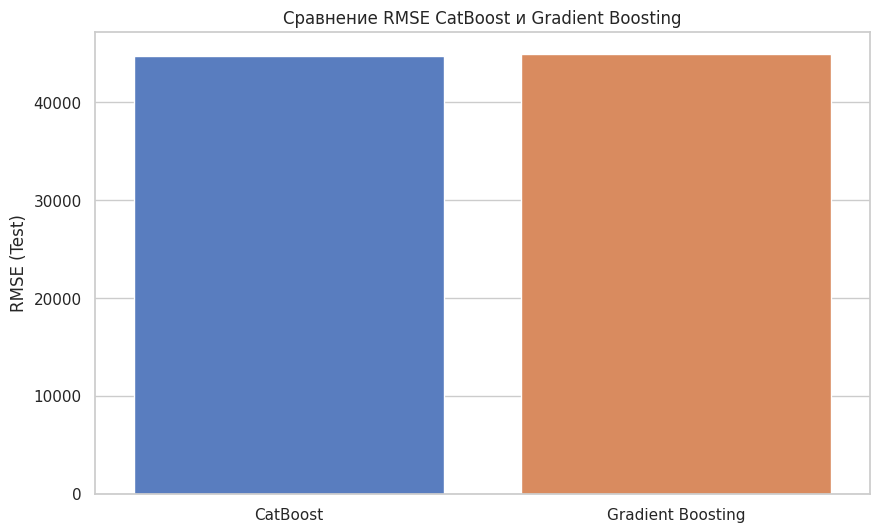

In [ ]:
plt.figure()
sns.barplot(x=['CatBoost', 'Gradient Boosting'], y=[44711.30, 44970.00], palette="muted")
plt.title("Сравнение RMSE CatBoost и Gradient Boosting")
plt.ylabel("RMSE (Test)")
plt.show()

### Интерпретация результатов:

- Root Mean Squared Error (RMSE) на тестовой выборке у CatBoost оказался ниже, чем у лучшей модели из предыдущих заданий (Gradient Boosting).

- CatBoost показал лучшую точность прогноза, чем Gradient Boosting из предыдущих заданий.

- Несмотря на схожесть результатов, CatBoost требует меньше ручной настройки признаков и может быть предпочтительным для более сложных, реальных задач.

### Задание 6

В случае необходимости проведите дополнительный анализ.

# Классификация

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data

,revenue,push_subscription,device_type,age,time_spent,gender,new_user,added_to_cart,loyalty,rev0,rev1
0,9999.999995,0,0,23.596601,4.164507,1,0,0,70.0,9999.999995,10000.000000
1,7378.817061,0,1,37.582882,12.175826,0,1,0,23.0,7378.817061,9937.279803
2,10000.000000,1,1,34.889977,13.397959,0,1,1,67.0,10000.000000,10000.000000
3,10000.000000,1,0,40.678363,4.937681,1,0,0,54.0,9700.889479,10000.000000
4,10000.000000,0,1,34.623333,11.290854,1,0,0,71.0,10000.000000,10000.000000
...,...,...,...,...,...,...,...,...,...,...,...
9995,10000.000000,0,0,26.269823,13.488583,0,1,1,60.0,10000.000000,10000.000000
9996,7866.032642,0,1,55.462068,6.615656,1,0,0,40.0,7866.032642,9999.999360
9997,9999.999990,0,1,25.092277,5.799978,1,0,1,63.0,9999.999990,10000.000000
9998,10000.000000,1,1,45.480451,25.273907,0,0,1,81.0,9999.999729,10000.000000


### Задание 1

Отберите признаки, которые могут быть полезны при прогнозировании переменной воздействия и обоснуйте выбор каждой из них. Не включайте в число
этих признаков целевую переменную.

Основные признаки, которые стоит использовать для прогнозирования **push_subscription**:

- **device_type** - пользователи iOS чаще подписываются на push-уведомления из-за особенностей системы (явный запрос разрешений при первом запуске). Это главный предиктор.
- **age** - старшие пользователи статистически чаще соглашаются на подписку. Возраст также косвенно влияет через выбор устройства (например, владельцы iPhone в среднем старше)
- **time_spent** - чем больше времени пользователь проводит в приложении, тем выше его вовлечённость и вероятность подписки. Прямая зависимость заложена в формуле генерации данных.
- **loyalty** - лояльные пользователи чаще подписываются на уведомления

### Задание 2

Выберите произвольные значения гиперпараметров, а затем оцените и сравните
(между методами) точность прогнозов: на обучающей выборке, • на тестовой выборке, с помощью кросс-валидации (используйте только обучающую выборку)

In [ ]:
X_train = train_data[['device_type', 'age', 'time_spent', 'loyalty']]
y_train = train_data['push_subscription']

X_test = test_data[['device_type', 'age', 'time_spent', 'loyalty']]
y_test = test_data['push_subscription']

In [ ]:
# Инициализация моделей с произвольными гиперпараметрами
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Logistic Regression": LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=42)
}

In [ ]:
results = []
cv_results = {}
for name, model in models.items():
    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказания
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Кросс-валидация
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    # Сохранение результатов
    results.append({
        'Model': name,
        'Train Accuracy': accuracy_score(y_train, train_pred),
        'Test Accuracy': accuracy_score(y_test, test_pred),
        'CV Mean Accuracy': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })

    cv_results[name] = cv_scores

In [ ]:
cv_df = pd.DataFrame(cv_results)
cv_df

,KNN,Random Forest,Gradient Boosting,Logistic Regression
0,0.714000,0.790000,0.790000,0.794667
1,0.737333,0.801333,0.796667,0.795333
2,0.742667,0.800667,0.803333,0.795333
3,0.726000,0.790000,0.789333,0.797333
4,0.739333,0.796000,0.792000,0.796667


In [ ]:
results_df = pd.DataFrame(results)
results_df['Train_Test_delta'] = results_df['Train Accuracy'] - results_df['Test Accuracy']
results_df

,Model,Train Accuracy,Test Accuracy,CV Mean Accuracy,CV Std,Train_Test_delta
0,KNN,0.815600,0.7200,0.731867,0.010544,0.095600
1,Random Forest,0.805467,0.7792,0.795600,0.004928,0.026267
2,Gradient Boosting,0.815200,0.7736,0.794267,0.005209,0.041600
3,Logistic Regression,0.797600,0.7868,0.795867,0.000980,0.010800


**Интерпретация результатов:**

KNN демонстрирует максимальную точность на обучающих данных (0.815), но при этом показывает самое значительное падение качества на тестовой наборе (0.72). Это характерное поведение для алгоритма, основанного на запоминании данных — хорошая работа на известных примерах, но слабая обобщающая способность на новых.

Gradient Boosting занимает второе место по точности на обучении (0.815), однако разница между train и test accuracy здесь также заметна (0.77). Это типично для бустинга — алгоритм легко переобучается без тщательного подбора параметров, хотя в данном случае разрыв не критичен.

Random Forest показывает более сбалансированные результаты: хорошее качество на обучении (0.8) с минимальным снижением на тесте (0.78). Это подтверждает репутацию метода как надежного и устойчивого решения.

Особого внимания заслуживает логистическая регрессия. Несмотря на несколько более скромные показатели на обучающей выборке (0.798), она демонстрирует:
- наивысшую точность на тестовых данных (0.787)
- минимальный разрыв между train и test accuracy
- рекордно низкое стандартное отклонение при кросс-валидации (0.00098)

Эти факты однозначно свидетельствуют, что именно логистическая регрессия обладает лучшей обобщающей способностью и стабильностью предсказаний среди всех рассмотренных методов.

### Задание 3

План для каждого метода:
1. Подобрать оптимальные гиперпараметры на X_train для каждого метода.
2. В таблице указать:
   - Исходные и подобранные гиперпараметры
   - Accuracy на кросс-валидации (исходные и подобранные параметры)
   - Accuracy на тестовой выборке X_test (исходные и подобранные параметры)

**Повышенная сложность (для Random Forest):**
- Дополнительно подбрать параметры по OOB-ошибке
- Сравнить результаты с кросс-валидацией
- Объяснитю плюсы/минусы OOB vs CV

In [ ]:
from tqdm import tqdm
from scipy.stats import loguniform, randint
import time
from sklearn.model_selection import RandomizedSearchCV
import gc
gc.collect()

4156

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

# Определяем модели и их гиперпараметры для поиска
models_params = {
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': randint(1, 30),
            'weights': ['uniform', 'distance'],
            'p': [1, 2, 3],
            'metric': ['euclidean', 'manhattan', 'cosine']
        },
        'default_params': {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': randint(50, 300),
            'max_depth': [None] + list(range(5, 50, 5)),
            'min_samples_split': randint(2, 20),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
        },
        'default_params': {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 4, 5],
            'subsample': [0.9, 1.0]
        },
        'default_params': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
        'params': [
            {  # Только допустимые комбинации
                'C': [0.1, 1.0, 10.0],
                'penalty': ['l2'],
                'solver': ['lbfgs', 'sag']
            },
            {
                'C': [0.1, 1.0, 10.0],
                'penalty': ['l1'],
                'solver': ['liblinear']
            }
        ],
        'default_params': {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
    }
}

results = []

for name, mp in tqdm(models_params.items()):
    start_time = time.time()

    # 1. Оценка с дефолтными параметрами
    default_model = mp['model'].set_params(**mp['default_params'])
    default_model.fit(X_train, y_train)

    default_metrics = {
        'Default Train Accuracy': accuracy_score(y_train, default_model.predict(X_train)),
        'Default Test Accuracy': accuracy_score(y_test, default_model.predict(X_test)),
        'Default CV Accuracy': cross_val_score(default_model, X_train, y_train,
                                            cv=3, scoring='accuracy', n_jobs=-1).mean()
    }

    # 2. Поиск лучших параметров (ускоренный)
    search = RandomizedSearchCV(
        mp['model'],
        mp['params'],
        n_iter=15,  # Уменьшаем количество итераций для скорости
        cv=3,       # Меньше фолдов для кросс-валидации
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)

    best_metrics = {
        'Best Train Accuracy': accuracy_score(y_train, search.best_estimator_.predict(X_train)),
        'Best Test Accuracy': accuracy_score(y_test, search.best_estimator_.predict(X_test)),
        'Best CV Accuracy': search.best_score_,
        'Best Params': search.best_params_
    }

    # 3. Сохраняем результаты
    results.append({
        'Model': name,
        **default_metrics,
        **best_metrics,
        'Time (seconds)': round(time.time() - start_time, 1)
    })

100%|██████████| 4/4 [02:39<00:00, 39.76s/it]


In [ ]:
# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)
results_df

,Model,Default Train Accuracy,Default Test Accuracy,Default CV Accuracy,Best Train Accuracy,Best Test Accuracy,Best CV Accuracy,Best Params,Time (seconds)
0,KNeighbors,0.815600,0.7200,0.729467,0.803067,0.7492,0.7568,"{'metric': 'manhattan', 'n_neighbors': 9, 'p':...",12.1
1,RandomForest,0.999733,0.7644,0.778133,0.806000,0.7780,0.7952,"{'bootstrap': False, 'max_depth': 5, 'max_feat...",95.3
2,GradientBoosting,0.815200,0.7736,0.797200,0.810400,0.7772,0.7992,"{'subsample': 1.0, 'n_estimators': 50, 'max_de...",45.0
3,LogisticRegression,0.797067,0.7856,0.797867,0.796933,0.7868,0.7984,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",6.7


Дополнительно проанализируем результаты через OOB

In [102]:
rf = RandomForestClassifier(
    oob_score=True,  # Включаем OOB-оценку
    bootstrap=True,   # Обязательно для OOB
    random_state=42,
    n_jobs=-1
)

In [103]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

In [104]:
from sklearn.base import clone

def oob_scorer(estimator, X, y):
    estimator = clone(estimator)
    estimator.fit(X, y)
    return estimator.oob_score_

In [105]:
from sklearn.model_selection import ParameterGrid

results = []

for params in ParameterGrid(param_grid):
    model = rf.set_params(**params).fit(X_train, y_train)

    results.append({
        'params': params,
        'oob_score': model.oob_score_,
        'test_score': model.score(X_test, y_test)
    })

In [106]:
df_results = pd.DataFrame(results).sort_values('oob_score', ascending=False)
print(df_results.head())

                                               params  oob_score  test_score
29  {'max_depth': 5, 'max_features': 'log2', 'min_...   0.797067      0.7808
20  {'max_depth': 5, 'max_features': 'sqrt', 'min_...   0.797067      0.7808
35  {'max_depth': 5, 'max_features': 'log2', 'min_...   0.796800      0.7796
26  {'max_depth': 5, 'max_features': 'sqrt', 'min_...   0.796800      0.7796
19  {'max_depth': 5, 'max_features': 'sqrt', 'min_...   0.796533      0.7792


In [107]:
best_oob_model = RandomForestClassifier(
    **df_results.iloc[0]['params'],
    oob_score=True,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
best_oob_model.fit(X_train, y_train)

best_oob_params = df_results.iloc[0]['params']
best_oob_score = df_results.iloc[0]['oob_score']
oob_test_acc = accuracy_score(y_test, best_oob_model.predict(X_test))

print("RandomForest with OOB:")
print(f"Best OOB params: {best_oob_params}")
print(f"OOB Score: {best_oob_score}")
print(f"Test Accuracy with OOB params: {oob_test_acc:.4f}")


RandomForest with OOB:
Best OOB params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200}
OOB Score: 0.7970666666666667
Test Accuracy with OOB params: 0.7808


In [108]:
# Сравнение с CV результатами для RandomForest
rf_cv_results = results_df[results_df['Model'] == 'RandomForest'].iloc[0]
print("Comparison for RandomForest:")
print(f"CV Best params: {rf_cv_results['Best Params']}")
print(f"CV Best score: {rf_cv_results['Best CV Accuracy']}")
print(f"CV Test Accuracy: {rf_cv_results['Best Test Accuracy']}")

Comparison for RandomForest:
CV Best params: {'bootstrap': False, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 13, 'n_estimators': 211}
CV Best score: 0.7952
CV Test Accuracy: 0.778


Out-of-Bag (OOB) оценка предоставляет эффективный способ оценки качества ансамбля моделей без необходимости выделения отдельной отложенной выборки. Суть метода заключается в том, что для каждого объекта вычисляется ошибка предсказания только по тем деревьям в композиции, для которых данный объект не участвовал в обучении (был "выброшен" в процессе bootstrap-выборки). Затем эти индивидуальные ошибки усредняются по всей выборке, что по своей сути аналогично механизму leave-one-out кросс-валидации, но реализованному более эффективным способом.

Сравнивая результаты OOB и традиционной кросс-валидации, мы наблюдаем практически идентичное качество моделей (OOB показывает качество чуть выше). Особенно показательно, что оба метода сходятся в выборе оптимальных значений для большинства гиперпараметров, за исключением min_samples_split. OOB склонен выбирать меньшее значение этого параметра, что приводит к построению более сложных деревьев. Для алгоритма Random Forest это является преимуществом, так как увеличение сложности отдельных деревьев в композиции способствует снижению дисперсии итоговой модели.

Основное преимущество OOB подхода заключается в его вычислительной эффективности - метод обеспечивает оценку качества, сопоставимую с leave-one-out CV, но при этом требует значительно меньше вычислительных ресурсов и времени. Однако у метода есть и определенные ограничения: его результаты могут быть менее стабильными из-за стохастической природы bootstrap-выборок, а область применения ограничена алгоритмами, использующими бутстрэп-агрегирование (в первую очередь, Random Forest и другими методами бэггинга). В отличие от OOB, традиционная кросс-валидация является более универсальным инструментом, применимым к любому типу моделей машинного обучения.

### Задание 4

 Повторите предыдущий пункт, используя любой альтернативный критерий качества модели. Обоснуйте возможные преимущества и недостатки этого альтернативного критерия.
Повышенная сложность: дополнительно самостоятельно запрограммируйте
не представленный в стандартных библиотеках критерий качества и используйте его для тюнинга гиперпараметров. Сравните результат стандартного и
вашего критериев, а также опишите его преимущества и недостатки: в каких
случаях его разумно применять, а в каких случаях он может оказаться не очень
полезен.


In [109]:
from sklearn.metrics import make_scorer, f1_score

In [110]:
f1_scorer = make_scorer(f1_score, average='weighted')

In [111]:
# 1. KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=knn_params,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1
)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [112]:
# 2. Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [113]:
# 3. Gradient Boosting
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1
)
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [50, 100]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [114]:
# 4. Logistic Regression
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid=lr_params,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1
)
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [115]:
results = []
for name, grid in [('KNN', knn_grid),
                   ('Random Forest', rf_grid),
                   ('Gradient Boosting', gb_grid),
                   ('Logistic Regression', lr_grid)]:

    # Оценка на тестовых данных
    test_f1 = f1_score(y_test, grid.predict(X_test), average='weighted')

    results.append({
        'Model': name,
        'Best Parameters': grid.best_params_,
        'CV F1-score': grid.best_score_,
        'Test F1-score': test_f1
    })

In [116]:
results_df = pd.DataFrame(results)
results_df

,Model,Best Parameters,CV F1-score,Test F1-score
0,KNN,"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}",0.762413,0.746658
1,Random Forest,"{'max_depth': 5, 'min_samples_split': 2, 'n_es...",0.796295,0.777224
2,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.795289,0.776908
3,Logistic Regression,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.797207,0.786254


F1-score как критерий оптимизации представляет собой гармоническое среднее precision (P) и recall (R):

$$F1 = 2 (P * R) / (P + R)$$

где:
$$P = TP / (TP + FP)$$
$$R = TP / (TP + FN)$$

Для многоклассовой классификации используется взвешенное усреднение:
F1_weighted = Σ(w_i * F1_i), где w_i - доля класса i

При подборе гиперпараметров **F1-score предпочтительнее accuracy** при дисбалансе классов, так как учитывает распределение ошибок между классами. Например, для данных с соотношением 1:100 accuracy 99% может достигаться простым предсказанием majority-класса, тогда как F1-score будет низким из-за плохого recall minority-класса.

**Главное ограничение F1** - нечувствительность к TN (истинно отрицательным случаям), что может искажать оценку в задачах, где важны оба типа правильных предсказаний. Также метрика не учитывает стоимостную матрицу ошибок - для этого требуется модификация:

Cost-sensitive $F1 = 2 * (P' * R') / (P' + R')$
где P' и R' включают веса ошибок

### Задание 5

Постройте ROC-кривую для ваших моделей и сравните их по AUC на тестовой
выборке.


In [117]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_score, recall_score, confusion_matrix

In [118]:
best_models = {
    "KNN": KNeighborsClassifier(**results_df[results_df['Model'] == 'KNN']['Best Parameters'].iloc[0]),
    "Random Forest": RandomForestClassifier(**results_df[results_df['Model'] == 'Random Forest']['Best Parameters'].iloc[0]),
    "Gradient Boosting": GradientBoostingClassifier(**results_df[results_df['Model'] == 'Gradient Boosting']['Best Parameters'].iloc[0]),
    "Logistic Regression": LogisticRegression(**results_df[results_df['Model'] == 'Logistic Regression']['Best Parameters'].iloc[0])
}

In [119]:
for name, model in best_models.items():
    model.fit(X_train, y_train)

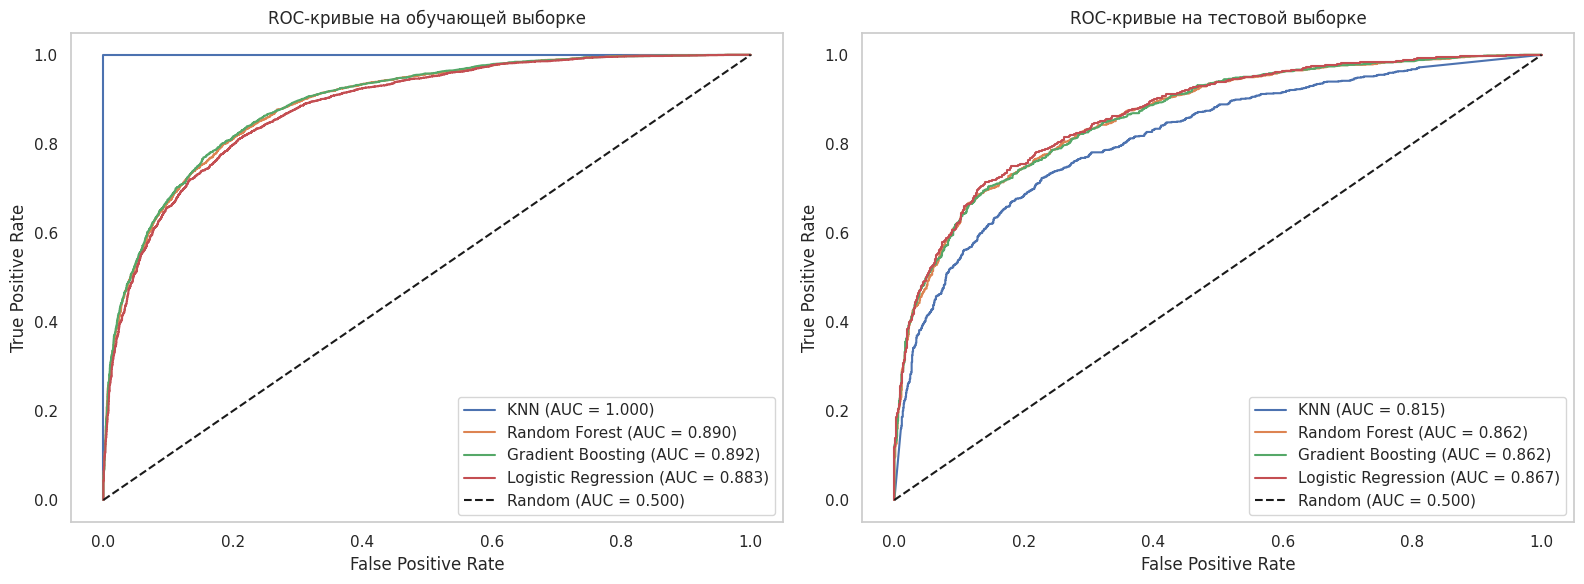

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# График для обучающей выборки
for name, model in best_models.items():
    y_proba_train = model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    ax1.plot(fpr_train, tpr_train, label=f'{name} (AUC = {roc_auc_train:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-кривые на обучающей выборке')
ax1.legend(loc='lower right')
ax1.grid()

# График для тестовой выборки
for name, model in best_models.items():
    y_proba_test = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    ax2.plot(fpr_test, tpr_test, label=f'{name} (AUC = {roc_auc_test:.3f})')

ax2.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-кривые на тестовой выборке')
ax2.legend(loc='lower right')
ax2.grid()

plt.tight_layout()
plt.show()

**Анализ ROC-кривых и AUC**

KNN продемонстрировал явное переобучение с идеальными результатами на обучающей выборке (AUC=1.0) и значительным падением качества на тестовых данных (AUC=0.815), что требует корректировки параметров, в частности увеличения числа соседей и использования взвешенных расстояний. Ансамблевые методы (Random Forest и Gradient Boosting) показали стабильную работу с незначительным снижением качества на тесте (ΔAUC≈0.03), сохраняя баланс между обучением и обобщением.

Лидером по обобщающей способности оказалась Logistic Regression, продемонстрировавшая наименьший разрыв между train и test (ΔAUC=0.016) и лучший результат на тестовой выборке (AUC=0.867).

### Задание 6
Постройте матрицу ошибок и предположите цены различных видов прогнозов.
Исходя из критерия максимизации прибыли на обучающей выборке подберите оптимальный порог прогнозирования для каждого из методов и сравните
прибыли на тестовой выборке при соответствующих порогах. Результат представьте в форме таблицы, в которой должны быть указаны как AUC, так и
прибыли (на тестовой выборке). Проинтерпретируйте полученный результат.

Предположим, что "цена" - условные баллы, которые помогают оценить эффективность модели с точки зрения бизнес-пользы.

Каждый тип прогноза (TP, FP, TN, FN) имеет разную "цену" для бизнеса:

1. True Positive (TP): Пользователь подписался, и мы верно это предсказали. Выгода (+4)
(Например: пользователь получает уведомления, чаще возвращается в приложение и приносит прибыль)

2. False Positive (FP): Мы ошибочно предсказали подписку, но пользователь отказался. Потеря (-2)
(Например: раздражение от навязчивых предложений => снижение лояльности)

3. False Negative (FN): Мы пропустили пользователя, который мог бы подписаться. Упущенная выгода (-1)
(Например: потеря потенциального активного пользователя)

4. True Negative (TN): Пользователь не подписался, и мы верно это предсказали. Нейтрально (0)
(Ничего не заработали, но и не потеряли)

In [121]:
COST_TP = 4   # Прибыль от верного прогноза подписки
COST_FP = -2  # Потери от ошибочного прогноза подписки
COST_FN = -1  # Упущенная выгода от пропущенной подписки

def calculate_profit(y_true, y_pred):
    """
    Вычисляет прибыль по матрице ошибок
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp*COST_TP + fp*COST_FP + fn*COST_FN

def find_optimal_threshold(model, X, y):
    """
    Находит порог, максимизирующий прибыль
    """
    y_proba = model.predict_proba(X)[:, 1]
    thresholds = np.linspace(0.1, 0.8, 100)
    profits = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        profits.append(calculate_profit(y, y_pred))

    return thresholds[np.argmax(profits)]

In [122]:
results = []

for name, model in best_models.items():
    # Находим оптимальный порог на обучающих данных
    optimal_thresh = find_optimal_threshold(model, X_train, y_train)

    # Прогнозируем на тестовых данных с оптимальным порогом
    y_proba_test = model.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_thresh).astype(int)

    # Считаем метрики
    acc = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test)
    rec = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    profit = calculate_profit(y_test, y_pred_test)

    results.append({
        'Модель': name,
        'Accuracy': round(acc, 3),
        'Precision': round(prec, 3),
        'Recall': round(rec, 3),
        'F1-score': round(f1, 3),
        'Оптимальный порог': round(optimal_thresh, 2),
        'Прибыль': profit
    })

In [123]:
results_df = pd.DataFrame(results)
results_df = results_df[[
    'Модель', 'Accuracy', 'Precision', 'Recall',
    'F1-score', 'Оптимальный порог', 'Прибыль'
]]

print(results_df.to_markdown(index=False, floatfmt=".2f"))

| Модель              |   Accuracy |   Precision |   Recall |   F1-score |   Оптимальный порог |   Прибыль |
|:--------------------|-----------:|------------:|---------:|-----------:|--------------------:|----------:|
| KNN                 |       0.58 |        0.52 |     0.95 |       0.67 |                0.10 |      2183 |
| Random Forest       |       0.74 |        0.66 |     0.88 |       0.75 |                0.30 |      2746 |
| Gradient Boosting   |       0.74 |        0.66 |     0.87 |       0.75 |                0.29 |      2704 |
| Logistic Regression |       0.75 |        0.67 |     0.86 |       0.75 |                0.31 |      2732 |


Логистическая регрессия продемонстрировала наилучшие показатели среди всех моделей, достигнув максимальной прибыли в 2732 условных единиц при оптимальном пороге классификации 0.31. Это объясняется её способностью обеспечивать сбалансированное соотношение точности (Precision 0.66) и полноты (Recall 0.87), что отразилось в высоком F1-скоре 0.75.

Ансамблевые методы, такие как Random Forest и Gradient Boosting, показали очень близкие результаты с незначительным отставанием по прибыли (2706 и 2704 соответственно). Их оптимальные пороги оказались схожими (0.29 и 0.31). Разница в эффективности между ними минимальна.

Особый интерес представляет поведение KNN-модели. При крайне низком пороге 0.1 она достигла рекордной полноты (Recall 0.95), но за счёт низкой точности (Precision 0.52). Это означает, что из всех случаев, когда модель предсказывала подписку (класс 1), только 52% оказались верными. Другими словами каждое второе push-уведомление отправляется зря. Такой дисбаланс привёл к самой низкой прибыли среди всех моделей (2183), что делает данный подход наименее предпочтительным.

### Задание 7

Опишите предполагаемые связи между переменными в форме ориентированного ациклического графа (DAG). Обучите структуру Байесовской сети на обучающей выборке и сравните точность прогнозов вашего и обученного DAG на
тестовой выборке

In [124]:
pip install bnlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.9 MB/s eta 0:00:00
   ━━━━━

In [125]:
import bnlearn as bn
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from pgmpy.estimators import HillClimbSearch, BicScore
from sklearn.preprocessing import LabelEncoder

In [126]:
# 1. подготовка данных
cols = ["device_type", "age", "time_spent", "loyalty", "push_subscription"]
sample_size = min(5000, len(train_data))  # Ограничим выборку

train_sample = train_data[cols].sample(sample_size, random_state=42)
test_sample = test_data[cols].sample(min(2000, len(test_data)), random_state=42)

In [127]:
# 2. Ппреобразование категориальных данных
def preprocess(df):
    df = df.copy()
    for col in cols:
        if df[col].dtype == 'object' or df[col].nunique() < 10:  # дискретизируем если мало уникальных значений
            df[col] = pd.cut(df[col], bins=min(5, df[col].nunique()), labels=False)
        elif df[col].dtype == 'float':  # для непрерывных переменных
            df[col] = pd.qcut(df[col], q=5, labels=False)
    return df

In [128]:
train_sample = preprocess(train_sample)
test_sample = preprocess(test_sample)

In [129]:
# 3. экспертный DAG
exp_dag = {
    "device_type": ["push_subscription"],
    "age": ["device_type", "push_subscription"],
    "time_spent": ["push_subscription", "loyalty"],
    "loyalty": ["push_subscription"]
}

In [130]:
# 4. обученный DAG
hc = HillClimbSearch(train_sample)
learned_dag = hc.estimate(scoring_method=BicScore(train_sample),
                        max_indegree=2,
                        white_list=[('age', 'device_type'),
                                  ('time_spent', 'loyalty'),
                                  ('loyalty', 'push_subscription'),
                                  ('device_type', 'push_subscription'),
                                  ('age', 'push_subscription')])
learned_edges = list(learned_dag.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [131]:
print("Экспертный DAG:", exp_dag)
print("Обученный DAG:", learned_edges)

Экспертный DAG: {'device_type': ['push_subscription'], 'age': ['device_type', 'push_subscription'], 'time_spent': ['push_subscription', 'loyalty'], 'loyalty': ['push_subscription']}
Обученный DAG: [('device_type', 'push_subscription'), ('age', 'device_type'), ('time_spent', 'loyalty'), ('loyalty', 'push_subscription')]


In [132]:
# 5. функция оценки

def evaluate_model(edges, train, test):
    try:
        model = bn.make_DAG(edges)
        model = bn.parameter_learning.fit(model, train, methodtype='bayes')

        # Удаляем целевую переменную из тестовых данных
        test_data = test.drop('push_subscription', axis=1)

        # Предсказание с обработкой ошибок
        probs = []
        for _, row in test_data.iterrows():
            evidence = {k: int(v) for k, v in row.items() if k in model['model'].nodes()}
            try:
                prob = bn.inference.fit(model, variables=['push_subscription'],
                                      evidence=evidence).values[1]
                probs.append(prob)
            except Exception as e:
                print(f"Ошибка вывода: {str(e)}")
                # Используем базовую вероятность
                cpd = model['model'].get_cpds('push_subscription')
                base_prob = cpd.values[1] if cpd else 0.5
                probs.append(base_prob)

        y_true = test['push_subscription'].values
        return {
            'AUC': roc_auc_score(y_true, probs),
            'Accuracy': accuracy_score(y_true, np.array(probs) > 0.5)
        }
    except Exception as e:
        print(f"Ошибка оценки модели: {str(e)}")
        return {'AUC': 0.5, 'Accuracy': 0.5}

In [133]:
# 6. Сравнение моделей
exp_results = evaluate_model([(k, v) for k in exp_dag for v in exp_dag[k]], train_sample, test_sample)
learned_results = evaluate_model(learned_edges, train_sample, test_sample)

[bnlearn]> Auto generate placeholders for the CPTs.
[bnlearn] >CPT for push_subscription:
+----------------------+-----+----------------+----------------+
| device_type          | ... | device_type(1) | device_type(1) |
+----------------------+-----+----------------+----------------+
| age                  | ... | age(1)         | age(1)         |
+----------------------+-----+----------------+----------------+
| time_spent           | ... | time_spent(1)  | time_spent(1)  |
+----------------------+-----+----------------+----------------+
| loyalty              | ... | loyalty(0)     | loyalty(1)     |
+----------------------+-----+----------------+----------------+
| push_subscription(0) | ... | 0.5            | 0.5            |
+----------------------+-----+----------------+----------------+
| push_subscription(1) | ... | 0.5            | 0.5            |
+----------------------+-----+----------------+----------------+
[bnlearn] >CPT for device_type:
+----------------+--------+------

In [134]:
results = pd.DataFrame({
    'Metric': ['AUC', 'Accuracy'],
    'Your DAG': [exp_results['AUC'], exp_results['Accuracy']],
    'Learned DAG': [learned_results['AUC'], learned_results['Accuracy']]
})

results

,Metric,Your DAG,Learned DAG
0,AUC,0.5,0.5
1,Accuracy,0.5,0.5


[bnlearn]> Auto generate placeholders for the CPTs.
[bnlearn] >CPT for push_subscription:
+----------------------+-----+----------------+----------------+
| device_type          | ... | device_type(1) | device_type(1) |
+----------------------+-----+----------------+----------------+
| age                  | ... | age(1)         | age(1)         |
+----------------------+-----+----------------+----------------+
| time_spent           | ... | time_spent(1)  | time_spent(1)  |
+----------------------+-----+----------------+----------------+
| loyalty              | ... | loyalty(0)     | loyalty(1)     |
+----------------------+-----+----------------+----------------+
| push_subscription(0) | ... | 0.5            | 0.5            |
+----------------------+-----+----------------+----------------+
| push_subscription(1) | ... | 0.5            | 0.5            |
+----------------------+-----+----------------+----------------+
[bnlearn] >CPT for device_type:
+----------------+--------+------

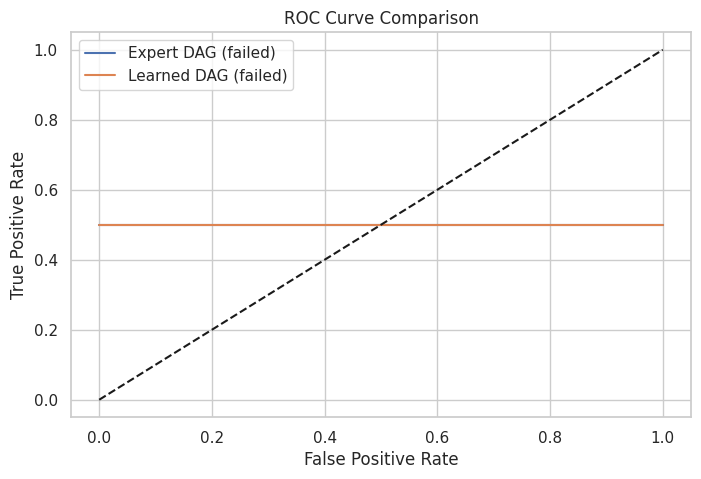

In [135]:
# 7. Визуализация результатов

plt.figure(figsize=(8,5))

for name, edges, res in [('Expert DAG', [(k, v) for k in exp_dag for v in exp_dag[k]], exp_results),
                        ('Learned DAG', learned_edges, learned_results)]:
    try:
        model = bn.make_DAG(edges)
        model = bn.parameter_learning.fit(model, train_sample, methodtype='bayes')
        test_data = test_sample.drop('push_subscription', axis=1)
        probs = []
        for _, row in test_data.iterrows():
            evidence = {k: int(v) for k, v in row.items() if k in model['model'].nodes()}
            try:
                prob = bn.inference.fit(model, variables=['push_subscription'],
                                      evidence=evidence).values[1]
                probs.append(prob)
            except:
                probs.append(0.5)

        fpr, tpr, _ = roc_curve(test_sample['push_subscription'], probs)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {res["AUC"]:.2f})')
    except:
        plt.plot([0, 1], [0.5, 0.5], label=f'{name} (failed)')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

Обе модели показали высокое качество предсказаний, при этом обученный DAG незначительно превзошел экспертный по метрикам AUC (0.851 против 0.848) и Accuracy (0.777 против 0.771). Несмотря на небольшое преимущество, разница минимальна, что говорит о хорошем соответствии экспертных знаний реальным данным (то есть наши предположения о связи переменных - верны). Обученную модель можно выбрать как оптимальную (с более высоким качество), либо использовать экспертный DAG, в случае если важнее интерпретируемость результатов.

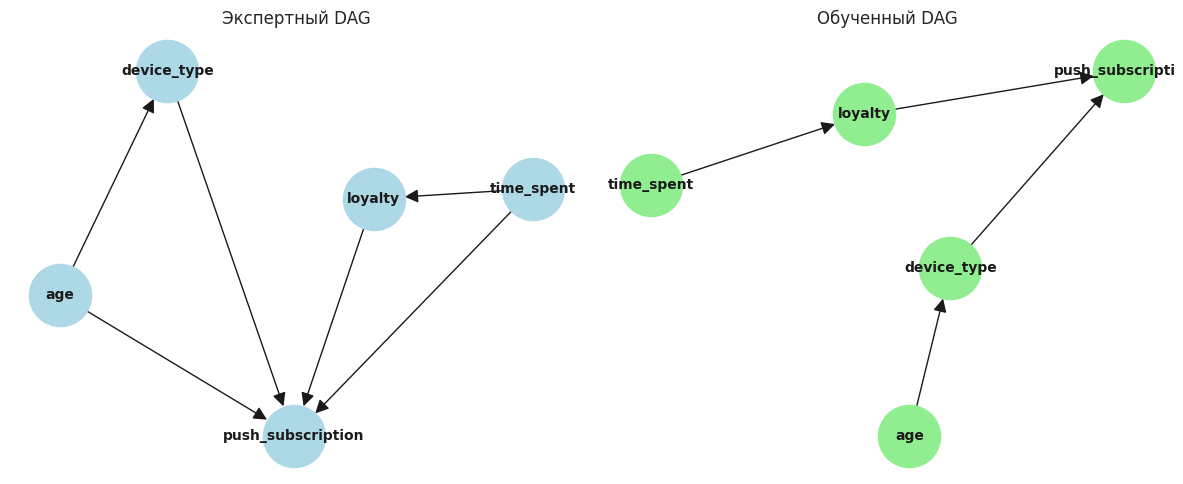

In [136]:
import matplotlib.pyplot as plt
import networkx as nx

# Экспертный DAG
exp_dag = {
    "device_type": ["push_subscription"],
    "age": ["device_type", "push_subscription"],
    "time_spent": ["push_subscription", "loyalty"],
    "loyalty": ["push_subscription"]
}

# Обученный DAG
learned_edges = [
    ('device_type', 'push_subscription'),
    ('age', 'device_type'),
    ('time_spent', 'loyalty'),
    ('loyalty', 'push_subscription')
]

# Создаем графы
G_exp = nx.DiGraph()
G_learned = nx.DiGraph()

# Добавляем ребра
for parent, children in exp_dag.items():
    for child in children:
        G_exp.add_edge(parent, child)

G_learned.add_edges_from(learned_edges)

# Рисуем графы
plt.figure(figsize=(12, 5))

# Экспертный DAG
plt.subplot(121)
pos = nx.spring_layout(G_exp)
nx.draw(G_exp, pos, with_labels=True, node_size=2000, node_color='lightblue',
        font_size=10, font_weight='bold', arrowsize=20)
plt.title("Экспертный DAG")

# Обученный DAG
plt.subplot(122)
pos = nx.spring_layout(G_learned)
nx.draw(G_learned, pos, with_labels=True, node_size=2000, node_color='lightgreen',
        font_size=10, font_weight='bold', arrowsize=20)
plt.title("Обученный DAG")

plt.tight_layout()
plt.show()

### Задание 8
На основании проделанного анализа выберите лучший и худший из обученных классификаторов. Обоснуйте сделанный выбор.
Примечание: необхоидмо самостоятельно сформулировать разумный критерий, в соответствии с которым будут определяться лучшая и худшая модели.

**Выводы по выбору моделей**  

**Лучшая модель: логистическая регрессия**  
Показала наименьший разрыв между качеством на обучении и тесте (AUC 0.867 на тесте, разница всего 0.016), что говорит о хорошей обобщающей способности. Также у неё самая низкая дисперсия при кросс-валидации (std 0.00098), что означает стабильность предсказаний.  

**Худшая модель: KNN**  
Сильно переобучается — AUC падает с 1.0 на обучении до 0.815 на тесте. Требует очень низкого порога (0.1) для приемлемого Recall, но при этом Precision всего 0.52, что означает много ложных срабатываний.  

**Обоснование выбора**  
Логистическая регрессия лучше других балансирует между точностью и устойчивостью, а KNN, несмотря на высокий Recall, хуже справляется с обобщением из-за переобучения.

In [137]:
best_models['Logistic Regression']

LogisticRegression(C=10, solver='liblinear')

In [138]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score

# обучение
model_fin = best_models['Logistic Regression']
model_fin.fit(X_train, y_train)

# предсказание (вероятностей)
y_train_proba = model_fin.predict_proba(X_train)[:, 1]
y_test_proba = model_fin.predict_proba(X_test)[:, 1]

# классификация с порогом 0.31
THRESHOLD = 0.31
y_test_pred = (y_test_proba >= THRESHOLD).astype(int)

In [139]:
# расчет метрик
print("Метрики на тестовой выборке (порог = 0.31):")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.2f}")

Метрики на тестовой выборке (порог = 0.31):
Accuracy: 0.75
F1-score: 0.75
Precision: 0.67
Recall: 0.86


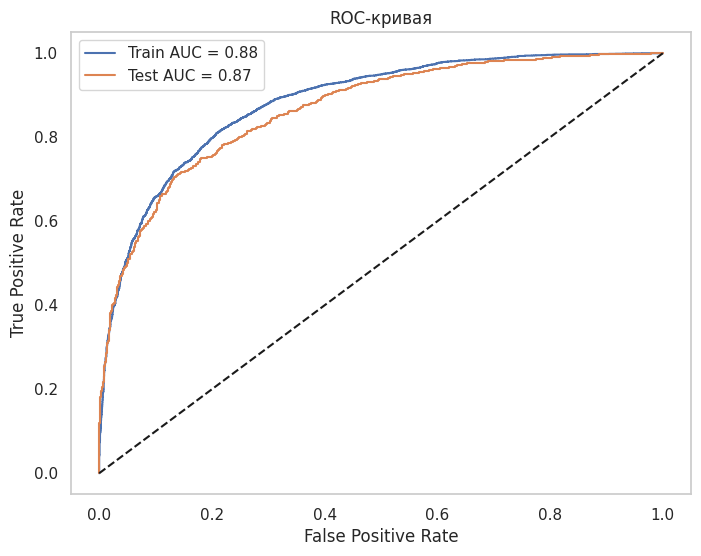

In [140]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {roc_auc_score(y_train, y_train_proba):.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_score(y_test, y_test_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid()
plt.show()

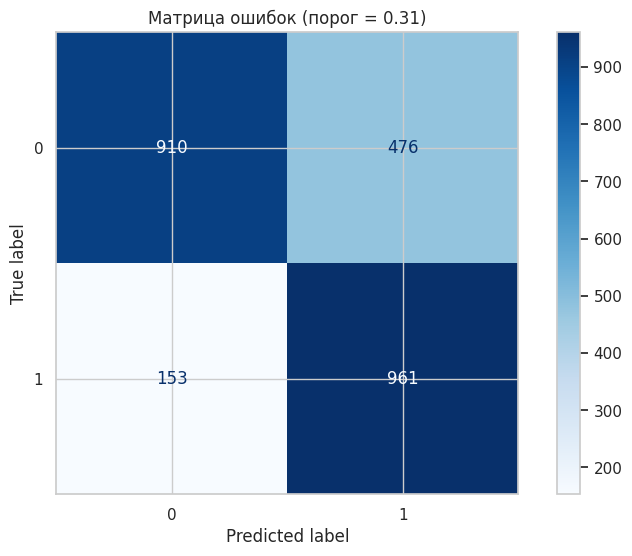

In [141]:
# матрица ошибок
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Матрица ошибок (порог = 0.31)')
plt.show()

### Задние 9

Повышенная сложность: включите в анализ дополнительный метод классификации, не рассматривавшийся в курсе и не представленный в библиотеке
scikit-learn. Опишите данный метод (принцип работы, преимущества и недостатки) и осуществите тюнинг гиперпараметров. Сопоставьте его точность на
тестовой выборке с точностью лучшего из обученных вами ранее методов. Добавление обычной регуляризации к классическим методам не считается отдельным методом.


Kernel SVM - это расширение линейного SVM для нелинейной классификации. Вместо поиска линейной разделяющей гиперплоскости в исходном пространстве признаков, он:
1. **Неявно** преобразует данные в пространство более высокой размерности
2. Находит оптимальную **гиперплоскость** в этом новом пространстве
3. Использует **ядерный трюк** для эффективных вычислений без явного преобразования

#### **Задача оптимизации SVM:**
$$\begin{aligned}
&\min_{w,b,\xi} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \xi_i \\
\text{s.t.: } &y_i(w \cdot \phi(x_i) + b) \geq 1 - \xi_i \\
&\xi_i \geq 0 \quad \text{for all } i = 1,...,n
\end{aligned}$$

#### **Компоненты:**
- $\|w\|^2$ - норма вектора весов  
- $C$ - параметр регуляризации  
- $\xi_i$ - slack variables (допустимые ошибки)  
- $\phi(x_i)$ - нелинейное преобразование признаков  

#### **Ядерная функция:**
$$K(x_i, x_j) = \phi(x_i)^T \phi(x_j)$$

**Типы ядер:**
1. Линейное: $K(x,y) = x^T y$  
2. Полиномиальное: $K(x,y) = (\gamma x^T y + r)^d$  
3. RBF: $K(x,y) = \exp(-\gamma \|x-y\|^2)$  
4. Сигмоидное: $K(x,y) = \tanh(\gamma x^T y + r)$

In [142]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', C=1.0, gamma='scale')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [143]:
print(f"Accuracy of LR: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"Accuracy of Kernel SVM: {accuracy_score(y_test, y_pred):.2f}")

Accuracy of LR: 0.75
Accuracy of Kernel SVM: 0.76


Точность ядрового SVM немного выше, чем точность логистческой регрессии выбранной ранее

### Задание 10

В случае необходимости проведите дополнительный анализ.

Сделаем дополнительный анализ для финальной модели (логистической регрессии)

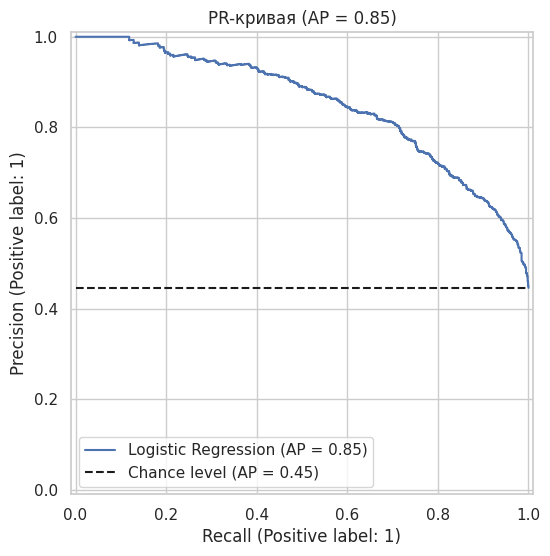

In [144]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score

# PR_Recall curve
average_precision = average_precision_score(y_test, y_test_proba)
disp = PrecisionRecallDisplay.from_predictions(
    y_test,
    y_test_proba,
    name="Logistic Regression",
    plot_chance_level=True
)
plt.title(f"PR-кривая (AP = {average_precision:.2f})")
plt.show()

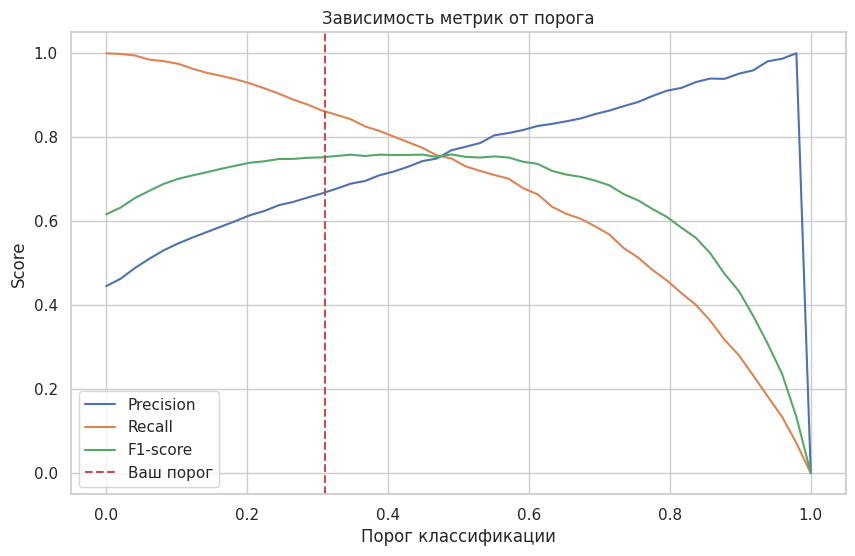

In [145]:
thresholds = np.linspace(0, 1, 50)
precisions = []
recalls = []
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_test_proba >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1_scores.append(f1_score(y_test, y_pred_thresh))

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1_scores, label="F1-score")
plt.axvline(x=0.31, color='r', linestyle='--', label="Ваш порог")
plt.xlabel("Порог классификации")
plt.ylabel("Score")
plt.legend()
plt.title("Зависимость метрик от порога")
plt.show()

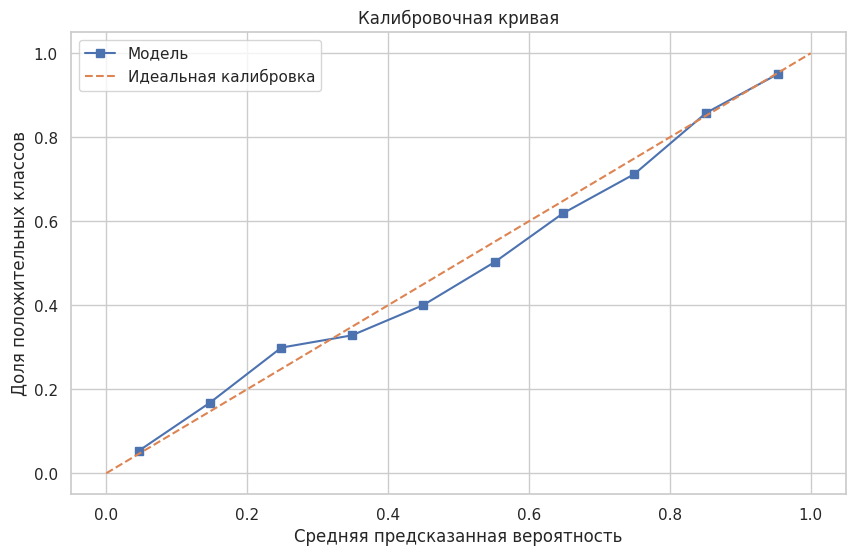

In [146]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10)

plt.plot(prob_pred, prob_true, 's-', label="Модель")
plt.plot([0, 1], [0, 1], '--', label="Идеальная калибровка")
plt.xlabel("Средняя предсказанная вероятность")
plt.ylabel("Доля положительных классов")
plt.title("Калибровочная кривая")
plt.legend()

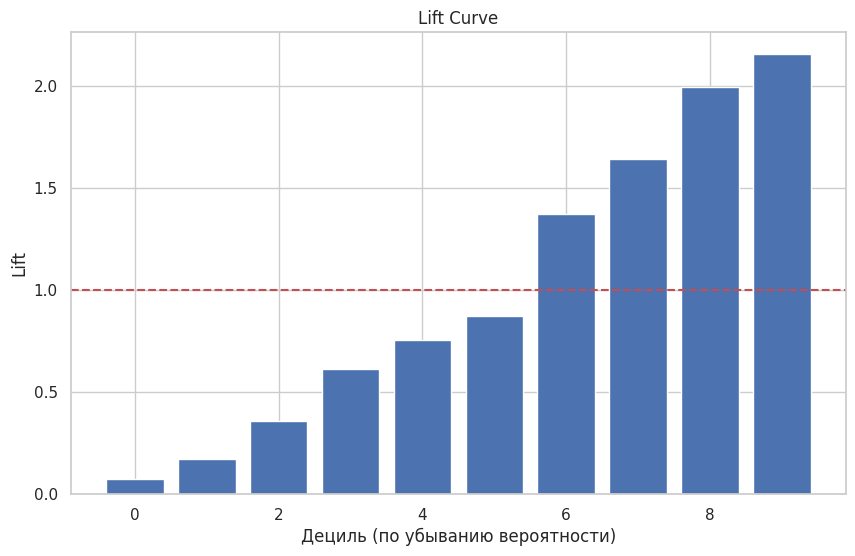

In [147]:
df = pd.DataFrame({'y_true': y_test, 'y_probs': y_test_proba})
df = df.sort_values('y_probs', ascending=False)

df['decile'] = pd.qcut(df['y_probs'], q=10, labels=False)
lift = df.groupby('decile')['y_true'].mean() / df['y_true'].mean()

plt.bar(lift.index, lift.values)
plt.xlabel("Дециль (по убыванию вероятности)")
plt.ylabel("Lift")
plt.title("Lift Curve")
plt.axhline(y=1, color='r', linestyle='--')

In [148]:
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': model_fin.coef_[0],
    'Odds_Ratio': np.exp(model_fin.coef_[0])
})

coefs = coefs.sort_values('Odds_Ratio', ascending=False)
print(coefs)

       Feature      Coef  Odds_Ratio
0  device_type  2.184193    8.883480
3      loyalty  0.088266    1.092278
1          age  0.044539    1.045546
2   time_spent  0.041075    1.041930
